# NIRCam Claw Detection
---
**Author**: Mees Fix (mfix@stsci.edu) <br>
**Latest Update**: 05 March 2025<br>
**Use case**: NIRCam Imaging detectors A1, A3, B1, B2 or B4. <br>
**Data**: None<br>
**Test Pipeline Version**: None

<a id='intro'></a>
## Introduction

This notebook demonstrates how to use JWST pointing information provided in a user's APT program to detect the potential of
[claws](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nircam-known-issues/nircam-scattered-light-artifacts#NIRCamScatteredLightArtifacts-clawsClaws) in NIRCam observations. Claws are a scattered light phenomenon that occur when a bright star falls in the susceptibility region. When present, claws occur primarily in the A1, A3, B1, B2 or B4 detectors, affecting roughly 5% of the pixels on those detectors.

All datasets necessary for this notebook to run are included in the [jwst_rogue_path_tool](https://github.com/spacetelescope/jwst_rogue_path_tool) python package. This includes the following:

* `APT_test_4RPtool.records.json`:  A mock program that contains NIRCam instrument configurations that could contain contain claws we want to detect.
* `rogue_path_nrca.fits`: fits file that contains the susceptibility region intensity contours for NIRCam module A. 
* `rogue_path_nrcb.fits`: fits file that contains the susceptibility region intensity contours for NIRCam module B.
* `two_mass_kmag_lt_5.csv`: [2MASS](https://irsa.ipac.caltech.edu/Missions/2mass.html) stellar sources that have magnitudes less than 5.

To generate your own `records.json` file for a specific program via APT, see the [JDox page for APT Export files](https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview/additional-jwst-apt-functionality/apt-export-files#APTExportFiles-records_filerecordsfile&gsc.tab=0).

<a id='top'></a>
## Table of Contents
* [Imports](#imports)
* [Run the JWST Rogue Path Tool](#Run-jwst-rpt)
    * [Handling records.json Files](#handle-records-json-files)
    * [Selecting and Displaying APT Data](#Selecting-displaying-program-data)
    * [Generating APT Program Object](#Generating-apt-program-object)
* [Plotting Rogue Path Tool Results](#Plotting-rogue-path-tool-results)
    * [Exposure Level Valid Angle Plots](#exposure-level-plots)
    * [Observation Level Valid Angle Plots](#observation-level-plots)
    * [Single Angle of Attitude in V2 & V3 Space Plots](#v2-vs-v3)
    * [Flux as a Function of Attitude Plots](#attitude-vs-flux)
* [Reporting & Applying PA Constraints in APT](#reporting-and-apt)

<a id='imports'></a>
## Imports

In [1]:
import numpy as np
import pathlib

from jwst_rogue_path_tool.program_data_parser import aptJsonFile
from jwst_rogue_path_tool.detect_claws import aptProgram
from jwst_rogue_path_tool.constants import PROJECT_DIRNAME

<a id='Run-jwst-rpt'></a>
## Run the JWST Rogue Path Tool

<a id='handle-records-json-files'></a>
### Handling records.json Files

Here we will look at the tools in the JWST Rogue Path Tool to parse and analyze the input data for the tool. The list of tables available are printed in a list below.

In [2]:
apt_json_filename = pathlib.Path(PROJECT_DIRNAME) / "data" / "APT_test_4RPtool.records.json"

# Parse the APT JSON file to obtain useful information for Claw Tool
parsed_json = aptJsonFile(apt_json_filename)

parsed_json.tablenames

['program',
 'observation',
 'mosaic',
 'target',
 'target_description',
 'fixed_target',
 'instruments',
 'visit',
 'visit_overheads',
 'visit_track',
 'visit_targets',
 'miri_templates',
 'miri_exposure_specification',
 'nircam_templates',
 'nircam_exposure_specification',
 'nircam_imaging_dither',
 'niriss_templates',
 'niriss_exposure_specification',
 'niriss_target_acq',
 'niriss_dither',
 'apt_diagnostics',
 'special_requirements',
 'link',
 'visit_linkspec',
 'exposures',
 'observation_association_candidates',
 'association_candidates']

<a id='Selecting-displaying-program-data'></a>
### Selecting and Displaying APT Data

Below we print the exposure level data from our program. This is a list of dictionaries, each dictionary in the list represents an observation.

In [3]:
tablename = "exposures"
parsed_json.data[tablename]  # This is a list of dictionaries

[{'program': 0,
  'observation': 1,
  'visit': 1,
  'exposure': 0,
  'pointing_sequence_number': 0,
  'exposure_spec_order_number': 0,
  'target_id': 1,
  'target_order_number': 0,
  'AperName': 'NRCALL_FULL',
  'apt_label': 'BASE',
  'dither_point_index': 0,
  'ideal_x_position': -58.0001799,
  'ideal_y_position': -23.4999796,
  'max_data_rate': 2.3005486156451145,
  'mosaic_tile_order_number': 0,
  'oss_AperName': 'NRCA5_FULL_OSS',
  'oss_ideal_x_position': -29.8773783,
  'oss_ideal_y_position': -22.7853593,
  'pointing_type': 'BASE',
  'v2': 56.0734166,
  'v3': -516.319756,
  'dark_parallel_slot_duration': 0,
  'external_parallel_slot_duration': 0},
 {'program': 0,
  'observation': 1,
  'visit': 1,
  'exposure': 1,
  'pointing_sequence_number': 1,
  'exposure_spec_order_number': 1,
  'target_id': 1,
  'target_order_number': 1,
  'AperName': 'NRCALL_FULL',
  'apt_label': 'SCIENCE',
  'data_volume_mib': 560.0,
  'dither_point_index': 1,
  'fixed_orient_used': 0.0,
  'ideal_x_position'

Here we are showing the same exposure level data but using a class method of `aptJsonFile` called `build_dataframe` to display the dictionaries as a Pandas DataFrame. Each row of the data frame represents a single exposure.

In [4]:
exposures_df = parsed_json.build_dataframe(tablename)
exposures_df  # this is a dataframe

,program,observation,visit,exposure,pointing_sequence_number,exposure_spec_order_number,target_id,target_order_number,AperName,apt_label,...,number_of_groups,number_of_integrations,number_of_scas,ra_center_rotation,dec_center_rotation,readout_pattern,region_shape,exposure_duration,photon_collecting_duration,visit_file_sequence
0,0,1,1,0,0,0,1,0,NRCALL_FULL,BASE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,1,1,1,1,1,NRCALL_FULL,SCIENCE,...,6.0,1.0,10.0,124.083819,19.237767,SHALLOW4,POLYGON ICRS 124.12942092617 19.21930240069 12...,381.0,311.366,NaN
2,0,1,1,2,2,1,1,1,NRCALL_FULL,SCIENCE,...,6.0,1.0,10.0,124.083885,19.237721,SHALLOW4,POLYGON ICRS 124.12948752365 19.21925638885 12...,350.0,311.366,NaN
3,0,1,2,0,0,0,1,0,NRCALL_FULL,BASE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,2,1,1,1,1,1,NRCALL_FULL,SCIENCE,...,6.0,1.0,10.0,124.100892,19.231261,SHALLOW4,POLYGON ICRS 124.14649015843 19.21279216436 12...,381.0,311.366,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0,10,1,2,8,4,1,1,MIRIM_ILLUM,SCIENCE,...,5.0,1.0,1.0,124.056125,19.321486,FASTR1,POLYGON ICRS 124.06556202123 19.30503354489 12...,43.0,13.875,2.0
207,0,10,1,3,9,4,1,1,NIS_CEN,SCIENCE,...,10.0,1.0,1.0,124.103734,19.23106,NIS,POLYGON ICRS 124.12321632568 19.21227397792 12...,465.0,429.471,1.0
208,0,10,1,3,9,4,1,1,MIRIM_ILLUM,SCIENCE,...,5.0,1.0,1.0,124.05598,19.321111,FASTR1,POLYGON ICRS 124.06541681078 19.30465884156 12...,43.0,13.875,2.0
209,0,10,1,1,10,5,1,1,NIS_CEN,DIRECT_IMAGE,...,4.0,1.0,1.0,124.103734,19.23106,NIS,POLYGON ICRS 124.12321632568 19.21227397792 12...,207.0,171.788,1.0


To display the entire dataframe:

```
import pandas as pd

pd.set_option('display.max_rows', len(exposures_df))
exposures_df
```

<a id='Generating-apt-program-object'></a>
### Generating APT Program Object

The cells above highlight the data that the JWST Rogue Path Tool uses to detect claws, the cells below show how we use the data from an APT file to detect claws in NIRCam imaging data.

To learn more about our API, we build our documentation using [ReadtheDocs](https://jwst-rogue-path-tool.readthedocs.io/en/latest/).

First, we start by importing our APT program of choice (`apt_json_filename`) and then we will sweep every angle of attitude (0.0 --> 359.0) degrees in intervals of 1.0 degree steps (`angular_step`).

In order to save time and memory in this example notebook, we use the `usr_defined_obs` keyword below to specify that we want to run the Rogue Path Tool only on Observations 1 and 5 in the APT file. `usr_defined_options` accepts a list of Observation numbers on which to run. Alternately, if you wish to run the tool on all Observations in the APT file, you can omit the `usr_defined_options` keyword.

In [5]:
program = aptProgram(apt_json_filename, angular_step=1.0, usr_defined_obs=[1, 5])

Run the Rogue Path Tool.

In [6]:
program.run()

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 1


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 6/360 [00:00<00:06, 54.95it/s]

  4%|▎         | 13/360 [00:00<00:05, 59.95it/s]

  6%|▌         | 20/360 [00:00<00:05, 61.55it/s]

  8%|▊         | 27/360 [00:00<00:05, 62.33it/s]

  9%|▉         | 34/360 [00:00<00:05, 62.77it/s]

 11%|█▏        | 41/360 [00:00<00:05, 62.92it/s]

 13%|█▎        | 48/360 [00:00<00:04, 63.07it/s]

 15%|█▌        | 55/360 [00:00<00:04, 63.09it/s]

 17%|█▋        | 62/360 [00:00<00:04, 63.24it/s]

 19%|█▉        | 69/360 [00:01<00:04, 63.24it/s]

 21%|██        | 76/360 [00:01<00:04, 63.42it/s]

 23%|██▎       | 83/360 [00:01<00:04, 63.47it/s]

 25%|██▌       | 90/360 [00:01<00:04, 63.60it/s]

 27%|██▋       | 97/360 [00:01<00:04, 63.60it/s]

 29%|██▉       | 104/360 [00:01<00:04, 63.62it/s]

 31%|███       | 111/360 [00:01<00:03, 63.26it/s]

 33%|███▎      | 118/360 [00:01<00:03, 62.95it/s]

 35%|███▍      | 125/360 [00:01<00:03, 63.12it/s]

 37%|███▋      | 132/360 [00:02<00:03, 62.54it/s]

 39%|███▊      | 139/360 [00:02<00:03, 57.57it/s]

 41%|████      | 146/360 [00:02<00:03, 58.52it/s]

 42%|████▎     | 153/360 [00:02<00:03, 59.83it/s]

 44%|████▍     | 160/360 [00:02<00:03, 52.28it/s]

 46%|████▋     | 167/360 [00:02<00:03, 55.30it/s]

 48%|████▊     | 174/360 [00:02<00:03, 57.54it/s]

 50%|█████     | 181/360 [00:02<00:03, 59.19it/s]

 52%|█████▏    | 188/360 [00:03<00:02, 60.46it/s]

 54%|█████▍    | 195/360 [00:03<00:02, 61.39it/s]

 56%|█████▌    | 202/360 [00:03<00:02, 62.02it/s]

 58%|█████▊    | 209/360 [00:03<00:02, 62.51it/s]

 60%|██████    | 216/360 [00:03<00:02, 62.77it/s]

 62%|██████▏   | 223/360 [00:03<00:02, 62.81it/s]

 64%|██████▍   | 230/360 [00:03<00:02, 62.13it/s]

 66%|██████▌   | 237/360 [00:03<00:01, 61.66it/s]

 68%|██████▊   | 244/360 [00:03<00:01, 62.25it/s]

 70%|██████▉   | 251/360 [00:04<00:01, 62.60it/s]

 72%|███████▏  | 258/360 [00:04<00:01, 62.90it/s]

 74%|███████▎  | 265/360 [00:04<00:01, 63.00it/s]

 76%|███████▌  | 272/360 [00:04<00:01, 63.22it/s]

 78%|███████▊  | 279/360 [00:04<00:01, 63.31it/s]

 79%|███████▉  | 286/360 [00:04<00:01, 63.33it/s]

 81%|████████▏ | 293/360 [00:04<00:01, 63.40it/s]

 83%|████████▎ | 300/360 [00:04<00:00, 62.82it/s]

 85%|████████▌ | 307/360 [00:04<00:00, 62.95it/s]

 87%|████████▋ | 314/360 [00:05<00:00, 63.15it/s]

 89%|████████▉ | 321/360 [00:05<00:00, 63.27it/s]

 91%|█████████ | 328/360 [00:05<00:00, 63.42it/s]

 93%|█████████▎| 335/360 [00:05<00:00, 63.52it/s]

 95%|█████████▌| 342/360 [00:05<00:00, 63.63it/s]

 97%|█████████▋| 349/360 [00:05<00:00, 63.60it/s]

 99%|█████████▉| 356/360 [00:05<00:00, 63.50it/s]

100%|██████████| 360/360 [00:05<00:00, 61.97it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 2


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 7/360 [00:00<00:05, 61.73it/s]

  4%|▍         | 14/360 [00:00<00:05, 62.41it/s]

  6%|▌         | 21/360 [00:00<00:05, 62.89it/s]

  8%|▊         | 28/360 [00:00<00:05, 63.10it/s]

 10%|▉         | 35/360 [00:00<00:05, 63.27it/s]

 12%|█▏        | 42/360 [00:00<00:05, 63.32it/s]

 14%|█▎        | 49/360 [00:00<00:04, 63.38it/s]

 16%|█▌        | 56/360 [00:00<00:04, 63.26it/s]

 18%|█▊        | 63/360 [00:00<00:04, 63.36it/s]

 19%|█▉        | 70/360 [00:01<00:04, 63.47it/s]

 21%|██▏       | 77/360 [00:01<00:04, 63.52it/s]

 23%|██▎       | 84/360 [00:01<00:04, 63.57it/s]

 25%|██▌       | 91/360 [00:01<00:04, 63.65it/s]

 27%|██▋       | 98/360 [00:01<00:04, 63.71it/s]

 29%|██▉       | 105/360 [00:01<00:04, 63.74it/s]

 31%|███       | 112/360 [00:01<00:03, 63.71it/s]

 33%|███▎      | 119/360 [00:01<00:03, 63.63it/s]

 35%|███▌      | 126/360 [00:02<00:03, 60.23it/s]

 37%|███▋      | 133/360 [00:02<00:03, 60.71it/s]

 39%|███▉      | 140/360 [00:02<00:03, 61.50it/s]

 41%|████      | 147/360 [00:02<00:03, 62.04it/s]

 43%|████▎     | 154/360 [00:02<00:03, 62.50it/s]

 45%|████▍     | 161/360 [00:02<00:03, 62.90it/s]

 47%|████▋     | 168/360 [00:02<00:03, 63.09it/s]

 49%|████▊     | 175/360 [00:02<00:02, 63.26it/s]

 51%|█████     | 182/360 [00:02<00:02, 63.26it/s]

 52%|█████▎    | 189/360 [00:03<00:02, 63.29it/s]

 54%|█████▍    | 196/360 [00:03<00:02, 63.32it/s]

 56%|█████▋    | 203/360 [00:03<00:02, 63.33it/s]

 58%|█████▊    | 210/360 [00:03<00:02, 63.37it/s]

 60%|██████    | 217/360 [00:03<00:02, 63.42it/s]

 62%|██████▏   | 224/360 [00:03<00:02, 63.44it/s]

 64%|██████▍   | 231/360 [00:03<00:02, 63.49it/s]

 66%|██████▌   | 238/360 [00:03<00:01, 63.52it/s]

 68%|██████▊   | 245/360 [00:03<00:01, 63.51it/s]

 70%|███████   | 252/360 [00:03<00:01, 63.14it/s]

 72%|███████▏  | 259/360 [00:04<00:01, 63.33it/s]

 74%|███████▍  | 266/360 [00:04<00:01, 63.42it/s]

 76%|███████▌  | 273/360 [00:04<00:01, 63.50it/s]

 78%|███████▊  | 280/360 [00:04<00:01, 63.48it/s]

 80%|███████▉  | 287/360 [00:04<00:01, 63.55it/s]

 82%|████████▏ | 294/360 [00:04<00:01, 63.33it/s]

 84%|████████▎ | 301/360 [00:04<00:00, 63.38it/s]

 86%|████████▌ | 308/360 [00:04<00:00, 63.39it/s]

 88%|████████▊ | 315/360 [00:04<00:00, 63.45it/s]

 89%|████████▉ | 322/360 [00:05<00:00, 63.52it/s]

 91%|█████████▏| 329/360 [00:05<00:00, 63.64it/s]

 93%|█████████▎| 336/360 [00:05<00:00, 63.60it/s]

 95%|█████████▌| 343/360 [00:05<00:00, 63.68it/s]

 97%|█████████▋| 350/360 [00:05<00:00, 63.73it/s]

 99%|█████████▉| 357/360 [00:05<00:00, 63.75it/s]

100%|██████████| 360/360 [00:05<00:00, 63.19it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 4


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 7/360 [00:00<00:05, 60.33it/s]

  4%|▍         | 14/360 [00:00<00:05, 61.54it/s]

  6%|▌         | 21/360 [00:00<00:05, 62.38it/s]

  8%|▊         | 28/360 [00:00<00:05, 62.75it/s]

 10%|▉         | 35/360 [00:00<00:05, 62.96it/s]

 12%|█▏        | 42/360 [00:00<00:05, 63.08it/s]

 14%|█▎        | 49/360 [00:00<00:04, 63.14it/s]

 16%|█▌        | 56/360 [00:00<00:04, 63.23it/s]

 18%|█▊        | 63/360 [00:01<00:04, 63.28it/s]

 19%|█▉        | 70/360 [00:01<00:04, 63.37it/s]

 21%|██▏       | 77/360 [00:01<00:04, 63.31it/s]

 23%|██▎       | 84/360 [00:01<00:04, 63.36it/s]

 25%|██▌       | 91/360 [00:01<00:04, 63.47it/s]

 27%|██▋       | 98/360 [00:01<00:04, 63.54it/s]

 29%|██▉       | 105/360 [00:01<00:04, 63.62it/s]

 31%|███       | 112/360 [00:01<00:03, 63.63it/s]

 33%|███▎      | 119/360 [00:01<00:03, 61.59it/s]

 35%|███▌      | 126/360 [00:02<00:03, 62.13it/s]

 37%|███▋      | 133/360 [00:02<00:03, 62.51it/s]

 39%|███▉      | 140/360 [00:02<00:03, 62.58it/s]

 41%|████      | 147/360 [00:02<00:03, 62.80it/s]

 43%|████▎     | 154/360 [00:02<00:03, 63.08it/s]

 45%|████▍     | 161/360 [00:02<00:03, 63.29it/s]

 47%|████▋     | 168/360 [00:02<00:03, 63.39it/s]

 49%|████▊     | 175/360 [00:02<00:02, 63.48it/s]

 51%|█████     | 182/360 [00:02<00:02, 63.59it/s]

 52%|█████▎    | 189/360 [00:02<00:02, 63.50it/s]

 54%|█████▍    | 196/360 [00:03<00:02, 63.40it/s]

 56%|█████▋    | 203/360 [00:03<00:02, 63.42it/s]

 58%|█████▊    | 210/360 [00:03<00:02, 63.39it/s]

 60%|██████    | 217/360 [00:03<00:02, 63.41it/s]

 62%|██████▏   | 224/360 [00:03<00:02, 63.41it/s]

 64%|██████▍   | 231/360 [00:03<00:02, 63.38it/s]

 66%|██████▌   | 238/360 [00:03<00:01, 63.31it/s]

 68%|██████▊   | 245/360 [00:03<00:01, 63.48it/s]

 70%|███████   | 252/360 [00:03<00:01, 63.60it/s]

 72%|███████▏  | 259/360 [00:04<00:01, 63.64it/s]

 74%|███████▍  | 266/360 [00:04<00:01, 63.64it/s]

 76%|███████▌  | 273/360 [00:04<00:01, 63.64it/s]

 78%|███████▊  | 280/360 [00:04<00:01, 63.32it/s]

 80%|███████▉  | 287/360 [00:04<00:01, 63.05it/s]

 82%|████████▏ | 294/360 [00:04<00:01, 62.95it/s]

 84%|████████▎ | 301/360 [00:04<00:00, 63.01it/s]

 86%|████████▌ | 308/360 [00:04<00:00, 63.17it/s]

 88%|████████▊ | 315/360 [00:04<00:00, 63.29it/s]

 89%|████████▉ | 322/360 [00:05<00:00, 63.38it/s]

 91%|█████████▏| 329/360 [00:05<00:00, 63.51it/s]

 93%|█████████▎| 336/360 [00:05<00:00, 63.59it/s]

 95%|█████████▌| 343/360 [00:05<00:00, 63.70it/s]

 97%|█████████▋| 350/360 [00:05<00:00, 63.73it/s]

 99%|█████████▉| 357/360 [00:05<00:00, 63.65it/s]

100%|██████████| 360/360 [00:05<00:00, 63.25it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 5


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 7/360 [00:00<00:05, 60.75it/s]

  4%|▍         | 14/360 [00:00<00:05, 62.22it/s]

  6%|▌         | 21/360 [00:00<00:05, 62.40it/s]

  8%|▊         | 28/360 [00:00<00:05, 62.64it/s]

 10%|▉         | 35/360 [00:00<00:05, 62.00it/s]

 12%|█▏        | 42/360 [00:00<00:05, 62.55it/s]

 14%|█▎        | 49/360 [00:00<00:04, 62.90it/s]

 16%|█▌        | 56/360 [00:00<00:04, 63.24it/s]

 18%|█▊        | 63/360 [00:01<00:04, 63.36it/s]

 19%|█▉        | 70/360 [00:01<00:04, 63.51it/s]

 21%|██▏       | 77/360 [00:01<00:04, 63.33it/s]

 23%|██▎       | 84/360 [00:01<00:04, 61.18it/s]

 25%|██▌       | 91/360 [00:01<00:04, 61.70it/s]

 27%|██▋       | 98/360 [00:01<00:04, 61.35it/s]

 29%|██▉       | 105/360 [00:01<00:04, 61.43it/s]

 31%|███       | 112/360 [00:01<00:04, 60.53it/s]

 33%|███▎      | 119/360 [00:01<00:03, 60.39it/s]

 35%|███▌      | 126/360 [00:02<00:03, 60.94it/s]

 37%|███▋      | 133/360 [00:02<00:03, 61.31it/s]

 39%|███▉      | 140/360 [00:02<00:03, 61.98it/s]

 41%|████      | 147/360 [00:02<00:03, 62.53it/s]

 43%|████▎     | 154/360 [00:02<00:03, 62.92it/s]

 45%|████▍     | 161/360 [00:02<00:03, 63.23it/s]

 47%|████▋     | 168/360 [00:02<00:03, 63.41it/s]

 49%|████▊     | 175/360 [00:02<00:02, 63.40it/s]

 51%|█████     | 182/360 [00:02<00:02, 63.48it/s]

 52%|█████▎    | 189/360 [00:03<00:02, 63.51it/s]

 54%|█████▍    | 196/360 [00:03<00:02, 63.57it/s]

 56%|█████▋    | 203/360 [00:03<00:02, 63.65it/s]

 58%|█████▊    | 210/360 [00:03<00:02, 63.64it/s]

 60%|██████    | 217/360 [00:03<00:02, 63.70it/s]

 62%|██████▏   | 224/360 [00:03<00:02, 63.67it/s]

 64%|██████▍   | 231/360 [00:03<00:02, 63.66it/s]

 66%|██████▌   | 238/360 [00:03<00:01, 63.65it/s]

 68%|██████▊   | 245/360 [00:03<00:01, 63.64it/s]

 70%|███████   | 252/360 [00:04<00:01, 63.66it/s]

 72%|███████▏  | 259/360 [00:04<00:01, 63.67it/s]

 74%|███████▍  | 266/360 [00:04<00:01, 63.72it/s]

 76%|███████▌  | 273/360 [00:04<00:01, 63.68it/s]

 78%|███████▊  | 280/360 [00:04<00:01, 63.64it/s]

 80%|███████▉  | 287/360 [00:04<00:01, 63.66it/s]

 82%|████████▏ | 294/360 [00:04<00:01, 62.97it/s]

 84%|████████▎ | 301/360 [00:04<00:00, 63.21it/s]

 86%|████████▌ | 308/360 [00:04<00:00, 63.36it/s]

 88%|████████▊ | 315/360 [00:05<00:00, 63.49it/s]

 89%|████████▉ | 322/360 [00:05<00:00, 63.61it/s]

 91%|█████████▏| 329/360 [00:05<00:00, 63.66it/s]

 93%|█████████▎| 336/360 [00:05<00:00, 63.74it/s]

 95%|█████████▌| 343/360 [00:05<00:00, 63.73it/s]

 97%|█████████▋| 350/360 [00:05<00:00, 63.92it/s]

 99%|█████████▉| 357/360 [00:05<00:00, 63.95it/s]

100%|██████████| 360/360 [00:05<00:00, 63.00it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 7


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 7/360 [00:00<00:05, 67.47it/s]

  4%|▍         | 14/360 [00:00<00:05, 64.88it/s]

  6%|▌         | 21/360 [00:00<00:05, 64.19it/s]

  8%|▊         | 28/360 [00:00<00:05, 63.99it/s]

 10%|▉         | 35/360 [00:00<00:05, 63.91it/s]

 12%|█▏        | 42/360 [00:00<00:04, 63.81it/s]

 14%|█▎        | 49/360 [00:00<00:04, 63.74it/s]

 16%|█▌        | 56/360 [00:00<00:04, 63.75it/s]

 18%|█▊        | 63/360 [00:00<00:04, 63.73it/s]

 19%|█▉        | 70/360 [00:01<00:04, 63.78it/s]

 21%|██▏       | 77/360 [00:01<00:04, 63.82it/s]

 23%|██▎       | 84/360 [00:01<00:04, 63.82it/s]

 25%|██▌       | 91/360 [00:01<00:04, 63.82it/s]

 27%|██▋       | 98/360 [00:01<00:04, 63.79it/s]

 29%|██▉       | 105/360 [00:01<00:04, 63.74it/s]

 31%|███       | 112/360 [00:01<00:03, 63.60it/s]

 33%|███▎      | 119/360 [00:01<00:03, 63.49it/s]

 35%|███▌      | 126/360 [00:01<00:03, 63.40it/s]

 37%|███▋      | 133/360 [00:02<00:03, 63.36it/s]

 39%|███▉      | 140/360 [00:02<00:03, 63.38it/s]

 41%|████      | 147/360 [00:02<00:03, 63.39it/s]

 43%|████▎     | 154/360 [00:02<00:03, 63.45it/s]

 45%|████▍     | 161/360 [00:02<00:03, 63.68it/s]

 47%|████▋     | 168/360 [00:02<00:03, 63.70it/s]

 49%|████▊     | 175/360 [00:02<00:02, 63.71it/s]

 51%|█████     | 182/360 [00:02<00:02, 63.72it/s]

 52%|█████▎    | 189/360 [00:02<00:02, 63.70it/s]

 54%|█████▍    | 196/360 [00:03<00:02, 63.62it/s]

 56%|█████▋    | 203/360 [00:03<00:02, 63.57it/s]

 58%|█████▊    | 210/360 [00:03<00:02, 63.63it/s]

 60%|██████    | 217/360 [00:03<00:02, 63.67it/s]

 62%|██████▏   | 224/360 [00:03<00:02, 63.74it/s]

 64%|██████▍   | 231/360 [00:03<00:02, 63.79it/s]

 66%|██████▌   | 238/360 [00:03<00:01, 63.80it/s]

 68%|██████▊   | 245/360 [00:03<00:01, 63.88it/s]

 70%|███████   | 252/360 [00:03<00:01, 63.93it/s]

 72%|███████▏  | 259/360 [00:04<00:01, 64.03it/s]

 74%|███████▍  | 266/360 [00:04<00:01, 64.05it/s]

 76%|███████▌  | 273/360 [00:04<00:01, 64.06it/s]

 78%|███████▊  | 280/360 [00:04<00:01, 64.01it/s]

 80%|███████▉  | 287/360 [00:04<00:01, 63.94it/s]

 82%|████████▏ | 294/360 [00:04<00:01, 63.87it/s]

 84%|████████▎ | 301/360 [00:04<00:00, 63.79it/s]

 86%|████████▌ | 308/360 [00:04<00:00, 63.78it/s]

 88%|████████▊ | 315/360 [00:04<00:00, 63.77it/s]

 89%|████████▉ | 322/360 [00:05<00:00, 63.73it/s]

 91%|█████████▏| 329/360 [00:05<00:00, 63.71it/s]

 93%|█████████▎| 336/360 [00:05<00:00, 63.69it/s]

 95%|█████████▌| 343/360 [00:05<00:00, 63.81it/s]

 97%|█████████▋| 350/360 [00:05<00:00, 63.88it/s]

 99%|█████████▉| 357/360 [00:05<00:00, 63.89it/s]

100%|██████████| 360/360 [00:05<00:00, 63.78it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 1 and Exposure: 8


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 7/360 [00:00<00:05, 61.43it/s]

  4%|▍         | 14/360 [00:00<00:05, 62.63it/s]

  6%|▌         | 21/360 [00:00<00:05, 63.13it/s]

  8%|▊         | 28/360 [00:00<00:05, 63.26it/s]

 10%|▉         | 35/360 [00:00<00:05, 63.40it/s]

 12%|█▏        | 42/360 [00:00<00:05, 63.42it/s]

 14%|█▎        | 49/360 [00:00<00:04, 63.45it/s]

 16%|█▌        | 56/360 [00:00<00:04, 63.45it/s]

 18%|█▊        | 63/360 [00:00<00:04, 63.50it/s]

 19%|█▉        | 70/360 [00:01<00:04, 63.39it/s]

 21%|██▏       | 77/360 [00:01<00:04, 63.40it/s]

 23%|██▎       | 84/360 [00:01<00:04, 63.28it/s]

 25%|██▌       | 91/360 [00:01<00:04, 63.26it/s]

 27%|██▋       | 98/360 [00:01<00:04, 63.35it/s]

 29%|██▉       | 105/360 [00:01<00:04, 62.87it/s]

 31%|███       | 112/360 [00:01<00:03, 62.99it/s]

 33%|███▎      | 119/360 [00:01<00:03, 62.28it/s]

 35%|███▌      | 126/360 [00:01<00:03, 62.66it/s]

 37%|███▋      | 133/360 [00:02<00:03, 62.85it/s]

 39%|███▉      | 140/360 [00:02<00:03, 62.98it/s]

 41%|████      | 147/360 [00:02<00:03, 63.19it/s]

 43%|████▎     | 154/360 [00:02<00:03, 62.11it/s]

 45%|████▍     | 161/360 [00:02<00:03, 62.44it/s]

 47%|████▋     | 168/360 [00:02<00:03, 62.66it/s]

 49%|████▊     | 175/360 [00:02<00:02, 62.91it/s]

 51%|█████     | 182/360 [00:02<00:02, 62.99it/s]

 52%|█████▎    | 189/360 [00:02<00:02, 63.07it/s]

 54%|█████▍    | 196/360 [00:03<00:02, 63.05it/s]

 56%|█████▋    | 203/360 [00:03<00:02, 62.75it/s]

 58%|█████▊    | 210/360 [00:03<00:02, 62.89it/s]

 60%|██████    | 217/360 [00:03<00:02, 62.90it/s]

 62%|██████▏   | 224/360 [00:03<00:02, 63.03it/s]

 64%|██████▍   | 231/360 [00:03<00:02, 63.11it/s]

 66%|██████▌   | 238/360 [00:03<00:01, 63.26it/s]

 68%|██████▊   | 245/360 [00:03<00:01, 63.37it/s]

 70%|███████   | 252/360 [00:03<00:01, 63.35it/s]

 72%|███████▏  | 259/360 [00:04<00:01, 63.36it/s]

 74%|███████▍  | 266/360 [00:04<00:01, 63.38it/s]

 76%|███████▌  | 273/360 [00:04<00:01, 63.39it/s]

 78%|███████▊  | 280/360 [00:04<00:01, 63.43it/s]

 80%|███████▉  | 287/360 [00:04<00:01, 63.46it/s]

 82%|████████▏ | 294/360 [00:04<00:01, 63.40it/s]

 84%|████████▎ | 301/360 [00:04<00:00, 63.41it/s]

 86%|████████▌ | 308/360 [00:04<00:00, 63.03it/s]

 88%|████████▊ | 315/360 [00:04<00:00, 63.03it/s]

 89%|████████▉ | 322/360 [00:05<00:00, 63.08it/s]

 91%|█████████▏| 329/360 [00:05<00:00, 63.10it/s]

 93%|█████████▎| 336/360 [00:05<00:00, 62.86it/s]

 95%|█████████▌| 343/360 [00:05<00:00, 63.05it/s]

 97%|█████████▋| 350/360 [00:05<00:00, 63.14it/s]

 99%|█████████▉| 357/360 [00:05<00:00, 63.26it/s]

100%|██████████| 360/360 [00:05<00:00, 63.09it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 5 and Exposure: 125


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 8/360 [00:00<00:04, 76.19it/s]

  4%|▍         | 16/360 [00:00<00:04, 75.56it/s]

  7%|▋         | 24/360 [00:00<00:04, 75.43it/s]

  9%|▉         | 32/360 [00:00<00:04, 75.13it/s]

 11%|█         | 40/360 [00:00<00:04, 74.33it/s]

 13%|█▎        | 48/360 [00:00<00:04, 74.97it/s]

 16%|█▌        | 56/360 [00:00<00:04, 75.18it/s]

 18%|█▊        | 64/360 [00:00<00:03, 75.17it/s]

 20%|██        | 72/360 [00:00<00:03, 75.41it/s]

 22%|██▏       | 80/360 [00:01<00:03, 75.64it/s]

 24%|██▍       | 88/360 [00:01<00:03, 75.73it/s]

 27%|██▋       | 96/360 [00:01<00:03, 76.04it/s]

 29%|██▉       | 104/360 [00:01<00:03, 76.18it/s]

 31%|███       | 112/360 [00:01<00:03, 74.98it/s]

 33%|███▎      | 120/360 [00:01<00:03, 75.04it/s]

 36%|███▌      | 128/360 [00:01<00:03, 75.06it/s]

 38%|███▊      | 136/360 [00:01<00:02, 75.12it/s]

 40%|████      | 144/360 [00:01<00:02, 75.05it/s]

 42%|████▏     | 152/360 [00:02<00:02, 75.37it/s]

 44%|████▍     | 160/360 [00:02<00:02, 75.74it/s]

 47%|████▋     | 168/360 [00:02<00:02, 75.81it/s]

 49%|████▉     | 176/360 [00:02<00:02, 75.60it/s]

 51%|█████     | 184/360 [00:02<00:02, 75.50it/s]

 53%|█████▎    | 192/360 [00:02<00:02, 75.36it/s]

 56%|█████▌    | 200/360 [00:02<00:02, 75.19it/s]

 58%|█████▊    | 208/360 [00:02<00:02, 75.36it/s]

 60%|██████    | 216/360 [00:02<00:01, 75.63it/s]

 62%|██████▏   | 224/360 [00:02<00:01, 75.64it/s]

 64%|██████▍   | 232/360 [00:03<00:01, 75.61it/s]

 67%|██████▋   | 240/360 [00:03<00:01, 75.04it/s]

 69%|██████▉   | 248/360 [00:03<00:01, 75.32it/s]

 71%|███████   | 256/360 [00:03<00:01, 75.44it/s]

 73%|███████▎  | 264/360 [00:03<00:01, 75.73it/s]

 76%|███████▌  | 272/360 [00:03<00:01, 76.08it/s]

 78%|███████▊  | 280/360 [00:03<00:01, 75.96it/s]

 80%|████████  | 288/360 [00:03<00:00, 75.81it/s]

 82%|████████▏ | 296/360 [00:03<00:00, 75.69it/s]

 84%|████████▍ | 304/360 [00:04<00:00, 75.55it/s]

 87%|████████▋ | 312/360 [00:04<00:00, 75.42it/s]

 89%|████████▉ | 320/360 [00:04<00:00, 75.65it/s]

 91%|█████████ | 328/360 [00:04<00:00, 75.94it/s]

 93%|█████████▎| 336/360 [00:04<00:00, 75.87it/s]

 96%|█████████▌| 344/360 [00:04<00:00, 76.00it/s]

 98%|█████████▊| 352/360 [00:04<00:00, 76.00it/s]

100%|██████████| 360/360 [00:04<00:00, 75.99it/s]

100%|██████████| 360/360 [00:04<00:00, 75.53it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 5 and Exposure: 126


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 8/360 [00:00<00:04, 73.62it/s]

  4%|▍         | 16/360 [00:00<00:04, 75.08it/s]

  7%|▋         | 24/360 [00:00<00:04, 75.83it/s]

  9%|▉         | 32/360 [00:00<00:04, 70.55it/s]

 11%|█         | 40/360 [00:00<00:04, 72.08it/s]

 13%|█▎        | 48/360 [00:00<00:04, 71.99it/s]

 16%|█▌        | 56/360 [00:00<00:04, 73.02it/s]

 18%|█▊        | 64/360 [00:00<00:04, 73.74it/s]

 20%|██        | 72/360 [00:00<00:03, 74.55it/s]

 22%|██▏       | 80/360 [00:01<00:03, 75.26it/s]

 24%|██▍       | 88/360 [00:01<00:03, 75.40it/s]

 27%|██▋       | 96/360 [00:01<00:03, 75.43it/s]

 29%|██▉       | 104/360 [00:01<00:03, 75.06it/s]

 31%|███       | 112/360 [00:01<00:03, 75.09it/s]

 33%|███▎      | 120/360 [00:01<00:03, 75.01it/s]

 36%|███▌      | 128/360 [00:01<00:03, 75.33it/s]

 38%|███▊      | 136/360 [00:01<00:02, 75.60it/s]

 40%|████      | 144/360 [00:01<00:02, 75.51it/s]

 42%|████▏     | 152/360 [00:02<00:02, 75.26it/s]

 44%|████▍     | 160/360 [00:02<00:02, 75.25it/s]

 47%|████▋     | 168/360 [00:02<00:02, 75.34it/s]

 49%|████▉     | 176/360 [00:02<00:02, 75.38it/s]

 51%|█████     | 184/360 [00:02<00:02, 74.74it/s]

 53%|█████▎    | 192/360 [00:02<00:02, 75.32it/s]

 56%|█████▌    | 200/360 [00:02<00:02, 75.49it/s]

 58%|█████▊    | 208/360 [00:02<00:02, 75.50it/s]

 60%|██████    | 216/360 [00:02<00:01, 75.55it/s]

 62%|██████▏   | 224/360 [00:02<00:01, 75.56it/s]

 64%|██████▍   | 232/360 [00:03<00:01, 75.57it/s]

 67%|██████▋   | 240/360 [00:03<00:01, 75.91it/s]

 69%|██████▉   | 248/360 [00:03<00:01, 76.33it/s]

 71%|███████   | 256/360 [00:03<00:01, 76.21it/s]

 73%|███████▎  | 264/360 [00:03<00:01, 76.10it/s]

 76%|███████▌  | 272/360 [00:03<00:01, 74.62it/s]

 78%|███████▊  | 280/360 [00:03<00:01, 74.86it/s]

 80%|████████  | 288/360 [00:03<00:00, 75.08it/s]

 82%|████████▏ | 296/360 [00:03<00:00, 75.46it/s]

 84%|████████▍ | 304/360 [00:04<00:00, 75.88it/s]

 87%|████████▋ | 312/360 [00:04<00:00, 75.92it/s]

 89%|████████▉ | 320/360 [00:04<00:00, 75.85it/s]

 91%|█████████ | 328/360 [00:04<00:00, 75.73it/s]

 93%|█████████▎| 336/360 [00:04<00:00, 75.66it/s]

 96%|█████████▌| 344/360 [00:04<00:00, 75.57it/s]

 98%|█████████▊| 352/360 [00:04<00:00, 75.78it/s]

100%|██████████| 360/360 [00:04<00:00, 76.03it/s]

100%|██████████| 360/360 [00:04<00:00, 75.16it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 5 and Exposure: 127


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 8/360 [00:00<00:04, 75.98it/s]

  4%|▍         | 16/360 [00:00<00:04, 75.56it/s]

  7%|▋         | 24/360 [00:00<00:04, 75.34it/s]

  9%|▉         | 32/360 [00:00<00:04, 75.31it/s]

 11%|█         | 40/360 [00:00<00:04, 75.20it/s]

 13%|█▎        | 48/360 [00:00<00:04, 75.54it/s]

 16%|█▌        | 56/360 [00:00<00:04, 75.79it/s]

 18%|█▊        | 64/360 [00:00<00:03, 75.80it/s]

 20%|██        | 72/360 [00:00<00:03, 75.75it/s]

 22%|██▏       | 80/360 [00:01<00:03, 75.81it/s]

 24%|██▍       | 88/360 [00:01<00:03, 75.80it/s]

 27%|██▋       | 96/360 [00:01<00:03, 75.69it/s]

 29%|██▉       | 104/360 [00:01<00:03, 75.89it/s]

 31%|███       | 112/360 [00:01<00:03, 76.11it/s]

 33%|███▎      | 120/360 [00:01<00:03, 75.95it/s]

 36%|███▌      | 128/360 [00:01<00:03, 75.81it/s]

 38%|███▊      | 136/360 [00:01<00:02, 75.61it/s]

 40%|████      | 144/360 [00:01<00:02, 75.49it/s]

 42%|████▏     | 152/360 [00:02<00:02, 75.44it/s]

 44%|████▍     | 160/360 [00:02<00:02, 75.78it/s]

 47%|████▋     | 168/360 [00:02<00:02, 76.13it/s]

 49%|████▉     | 176/360 [00:02<00:02, 76.03it/s]

 51%|█████     | 184/360 [00:02<00:02, 75.87it/s]

 53%|█████▎    | 192/360 [00:02<00:02, 75.63it/s]

 56%|█████▌    | 200/360 [00:02<00:02, 75.54it/s]

 58%|█████▊    | 208/360 [00:02<00:02, 75.45it/s]

 60%|██████    | 216/360 [00:02<00:01, 75.68it/s]

 62%|██████▏   | 224/360 [00:02<00:01, 75.92it/s]

 64%|██████▍   | 232/360 [00:03<00:01, 75.92it/s]

 67%|██████▋   | 240/360 [00:03<00:01, 75.91it/s]

 69%|██████▉   | 248/360 [00:03<00:01, 75.93it/s]

 71%|███████   | 256/360 [00:03<00:01, 75.99it/s]

 73%|███████▎  | 264/360 [00:03<00:01, 75.92it/s]

 76%|███████▌  | 272/360 [00:03<00:01, 76.11it/s]

 78%|███████▊  | 280/360 [00:03<00:01, 76.30it/s]

 80%|████████  | 288/360 [00:03<00:00, 76.11it/s]

 82%|████████▏ | 296/360 [00:03<00:00, 75.92it/s]

 84%|████████▍ | 304/360 [00:04<00:00, 75.77it/s]

 87%|████████▋ | 312/360 [00:04<00:00, 75.73it/s]

 89%|████████▉ | 320/360 [00:04<00:00, 75.67it/s]

 91%|█████████ | 328/360 [00:04<00:00, 75.93it/s]

 93%|█████████▎| 336/360 [00:04<00:00, 76.31it/s]

 96%|█████████▌| 344/360 [00:04<00:00, 76.31it/s]

 98%|█████████▊| 352/360 [00:04<00:00, 76.23it/s]

100%|██████████| 360/360 [00:04<00:00, 76.04it/s]

100%|██████████| 360/360 [00:04<00:00, 75.83it/s]

Sweeping angles 0.0 --> 359.0 for Observation: 5 and Exposure: 128


  0%|          | 0/360 [00:00<?, ?it/s]

  2%|▏         | 8/360 [00:00<00:04, 75.81it/s]

  4%|▍         | 16/360 [00:00<00:04, 75.42it/s]

  7%|▋         | 24/360 [00:00<00:04, 75.45it/s]

  9%|▉         | 32/360 [00:00<00:04, 75.10it/s]

 11%|█         | 40/360 [00:00<00:04, 75.30it/s]

 13%|█▎        | 48/360 [00:00<00:04, 75.43it/s]

 16%|█▌        | 56/360 [00:00<00:04, 75.44it/s]

 18%|█▊        | 64/360 [00:00<00:03, 75.55it/s]

 20%|██        | 72/360 [00:00<00:03, 75.56it/s]

 22%|██▏       | 80/360 [00:01<00:03, 75.83it/s]

 24%|██▍       | 88/360 [00:01<00:03, 76.07it/s]

 27%|██▋       | 96/360 [00:01<00:03, 76.10it/s]

 29%|██▉       | 104/360 [00:01<00:03, 75.87it/s]

 31%|███       | 112/360 [00:01<00:03, 75.75it/s]

 33%|███▎      | 120/360 [00:01<00:03, 75.63it/s]

 36%|███▌      | 128/360 [00:01<00:03, 75.62it/s]

 38%|███▊      | 136/360 [00:01<00:02, 75.92it/s]

 40%|████      | 144/360 [00:01<00:02, 76.18it/s]

 42%|████▏     | 152/360 [00:02<00:02, 76.13it/s]

 44%|████▍     | 160/360 [00:02<00:02, 75.66it/s]

 47%|████▋     | 168/360 [00:02<00:02, 75.64it/s]

 49%|████▉     | 176/360 [00:02<00:02, 75.67it/s]

 51%|█████     | 184/360 [00:02<00:02, 75.57it/s]

 53%|█████▎    | 192/360 [00:02<00:02, 75.68it/s]

 56%|█████▌    | 200/360 [00:02<00:02, 75.28it/s]

 58%|█████▊    | 208/360 [00:02<00:02, 75.36it/s]

 60%|██████    | 216/360 [00:02<00:01, 75.35it/s]

 62%|██████▏   | 224/360 [00:02<00:01, 75.43it/s]

 64%|██████▍   | 232/360 [00:03<00:01, 75.42it/s]

 67%|██████▋   | 240/360 [00:03<00:01, 75.55it/s]

 69%|██████▉   | 248/360 [00:03<00:01, 75.94it/s]

 71%|███████   | 256/360 [00:03<00:01, 76.31it/s]

 73%|███████▎  | 264/360 [00:03<00:01, 76.31it/s]

 76%|███████▌  | 272/360 [00:03<00:01, 76.14it/s]

 78%|███████▊  | 280/360 [00:03<00:01, 76.07it/s]

 80%|████████  | 288/360 [00:03<00:00, 75.93it/s]

 82%|████████▏ | 296/360 [00:03<00:00, 75.79it/s]

 84%|████████▍ | 304/360 [00:04<00:00, 74.77it/s]

 87%|████████▋ | 312/360 [00:04<00:00, 75.32it/s]

 89%|████████▉ | 320/360 [00:04<00:00, 75.34it/s]

 91%|█████████ | 328/360 [00:04<00:00, 75.30it/s]

 93%|█████████▎| 336/360 [00:04<00:00, 75.41it/s]

 96%|█████████▌| 344/360 [00:04<00:00, 75.56it/s]

 98%|█████████▊| 352/360 [00:04<00:00, 75.54it/s]

100%|██████████| 360/360 [00:04<00:00, 75.86it/s]

100%|██████████| 360/360 [00:04<00:00, 75.66it/s]

... Averaging intensities per angle ...


... Calculating flux values ...


... Calculating backgrounds and thresholds ...


One all of the angles are swept and all meta data on potential claw are collected, we can inspect the output. The data structure is organized in the following way

```
program.observations.data (shows all of the meta data for the program)
program.observations.data[observation_id_number] (shows meta data a single observation)
```

If you are unsure about which observations from your program were used by the `jwst_rogue_path_tool` use the following commands

In [7]:
program.observations.supported_observations  # Only show the supported observations for JWST Rogue Path Tool
program.observations.supported_observations.keys()  # Observation numbers to select data on

dict_keys([1, 5])

For this example, let's use observation 1

In [8]:
program.observations.data[1]

{'visit':    program  observation  visit       apt_prd_name  apt_version  data_volume  \
 0        0            1      1  PRDAPTSOC-068-002       2025.1  1255.017302   
 1        0            1      2  PRDAPTSOC-068-002       2025.1  1255.017302   
 2        0            1      3  PRDAPTSOC-068-002       2025.1  1255.017302   
 
   defer_orient_selection internal_target  max_data_rate mosaic  ...  \
 0                      N               N       2.300549      N  ...   
 1                      N               N       2.300549      N  ...   
 2                      N               N       2.300549      N  ...   
 
              visit_type charged_duration  guide_star_acquisition_duration  \
 0  PRIME_TARGETED_FIXED             1707                              151   
 1  PRIME_TARGETED_FIXED             1809                              151   
 2  PRIME_TARGETED_FIXED             1759                              151   
 
   initial_overhead_duration overhead_duration  scheduling_durati

Each dictionary key contains specific information about the observation:

* **visit** : pandas data frame containing informations about the visits in the observation
* **ra** : Right ascension value of target
* **dec** : Declination value of target
* **nircam_exposure_specification**: Pandas dataframe of specifics instrument configurations for NRC exposures
* **nircam_templates** : Pandas dataframe containing information on which visit uses which NRC detector module
* **valid_starts_angles** : Numpy array containing the starting angles of sweeps with no claws
* **valid_ends_angles** : Numpy array containing the ending angles of sweeps with no claws
* **exposure_frames** : [See docs for explanation](https://jwst-rogue-path-tool.readthedocs.io/en/stable/jwst_rogue_path_tool.html#jwst_rogue_path_tool.detect_claws.exposureFrames.build_exposure_frames_data)
* **averages_A** : Statistical averages for NRC module A (displayed in V3PA vs Flux plots) (if there is no A module data, this key won't appear)
* **averages_B** : Statistical averages for NRC module B (displayed in V3PA vs Flux plots) (if there is no B module data, this key won't appear)
* **filters** : Pandas Series containing filters used in observation
* **pupils** Pandas Series containing pupils used in observation
* **flux** Dictionary containing flux values at each position angle. The key names depend on filter and pupil combination and are in units of counts and dn_pix_ks
* **flux_boolean** : dictionary containing boolean arrays. These arrays denote where flux values surpass or the statistical limits set.

<a id='Plotting-rogue-path-tool-results'></a>
## Plotting Rogue Path Tool Results

<a id='exposure-level-plots'></a>
### Exposure Level Valid Angle Plots

The following cells show how to generate figures at the exposure level for which position angles contain claws. The target is centered in the figures with a red x, the pink circles are "bright" targets from the [2MASS Survey](https://irsa.ipac.caltech.edu/Missions/2mass.html) that have a k band magnitude less than 5. The plotted stars are selected by an annulus which can be parsed to the plotting function as keyword arguments `inner_radius` and `outer_radius`. By default they are set to `inner_radius=8.0` and `outer_radius=12.0` in arcseconds. The green "pie slices" or "wedges" are the angles where these targets fall in the susceptibility region which is represented by the light blue polygons overlayed on the targets. Where you don't see wedges or the susceptibility region plotted

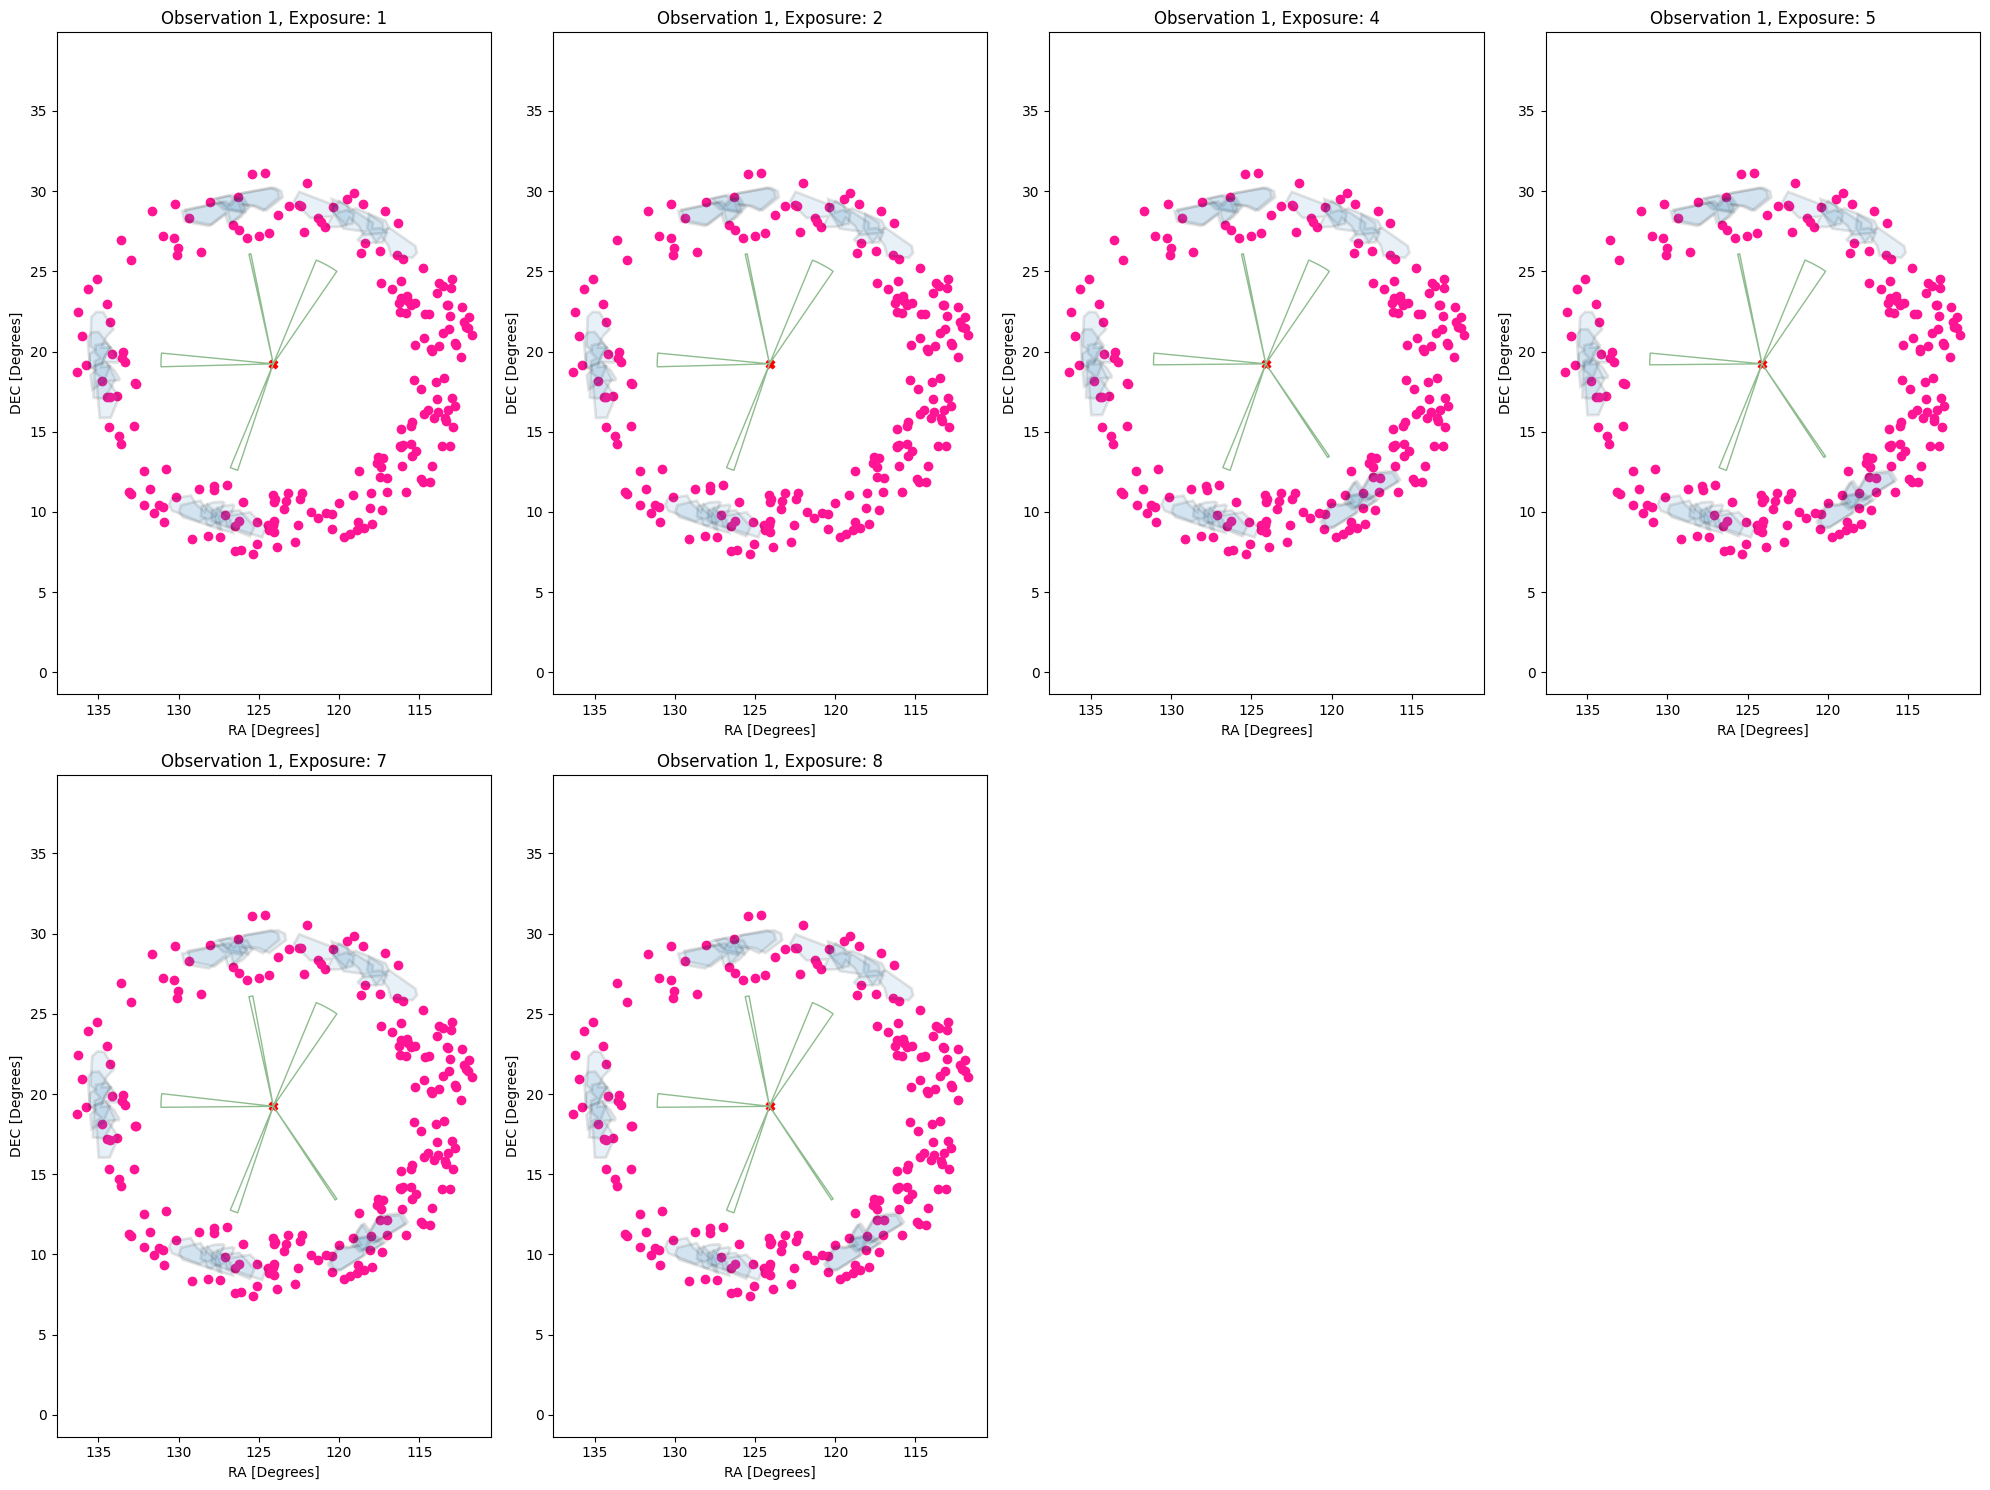

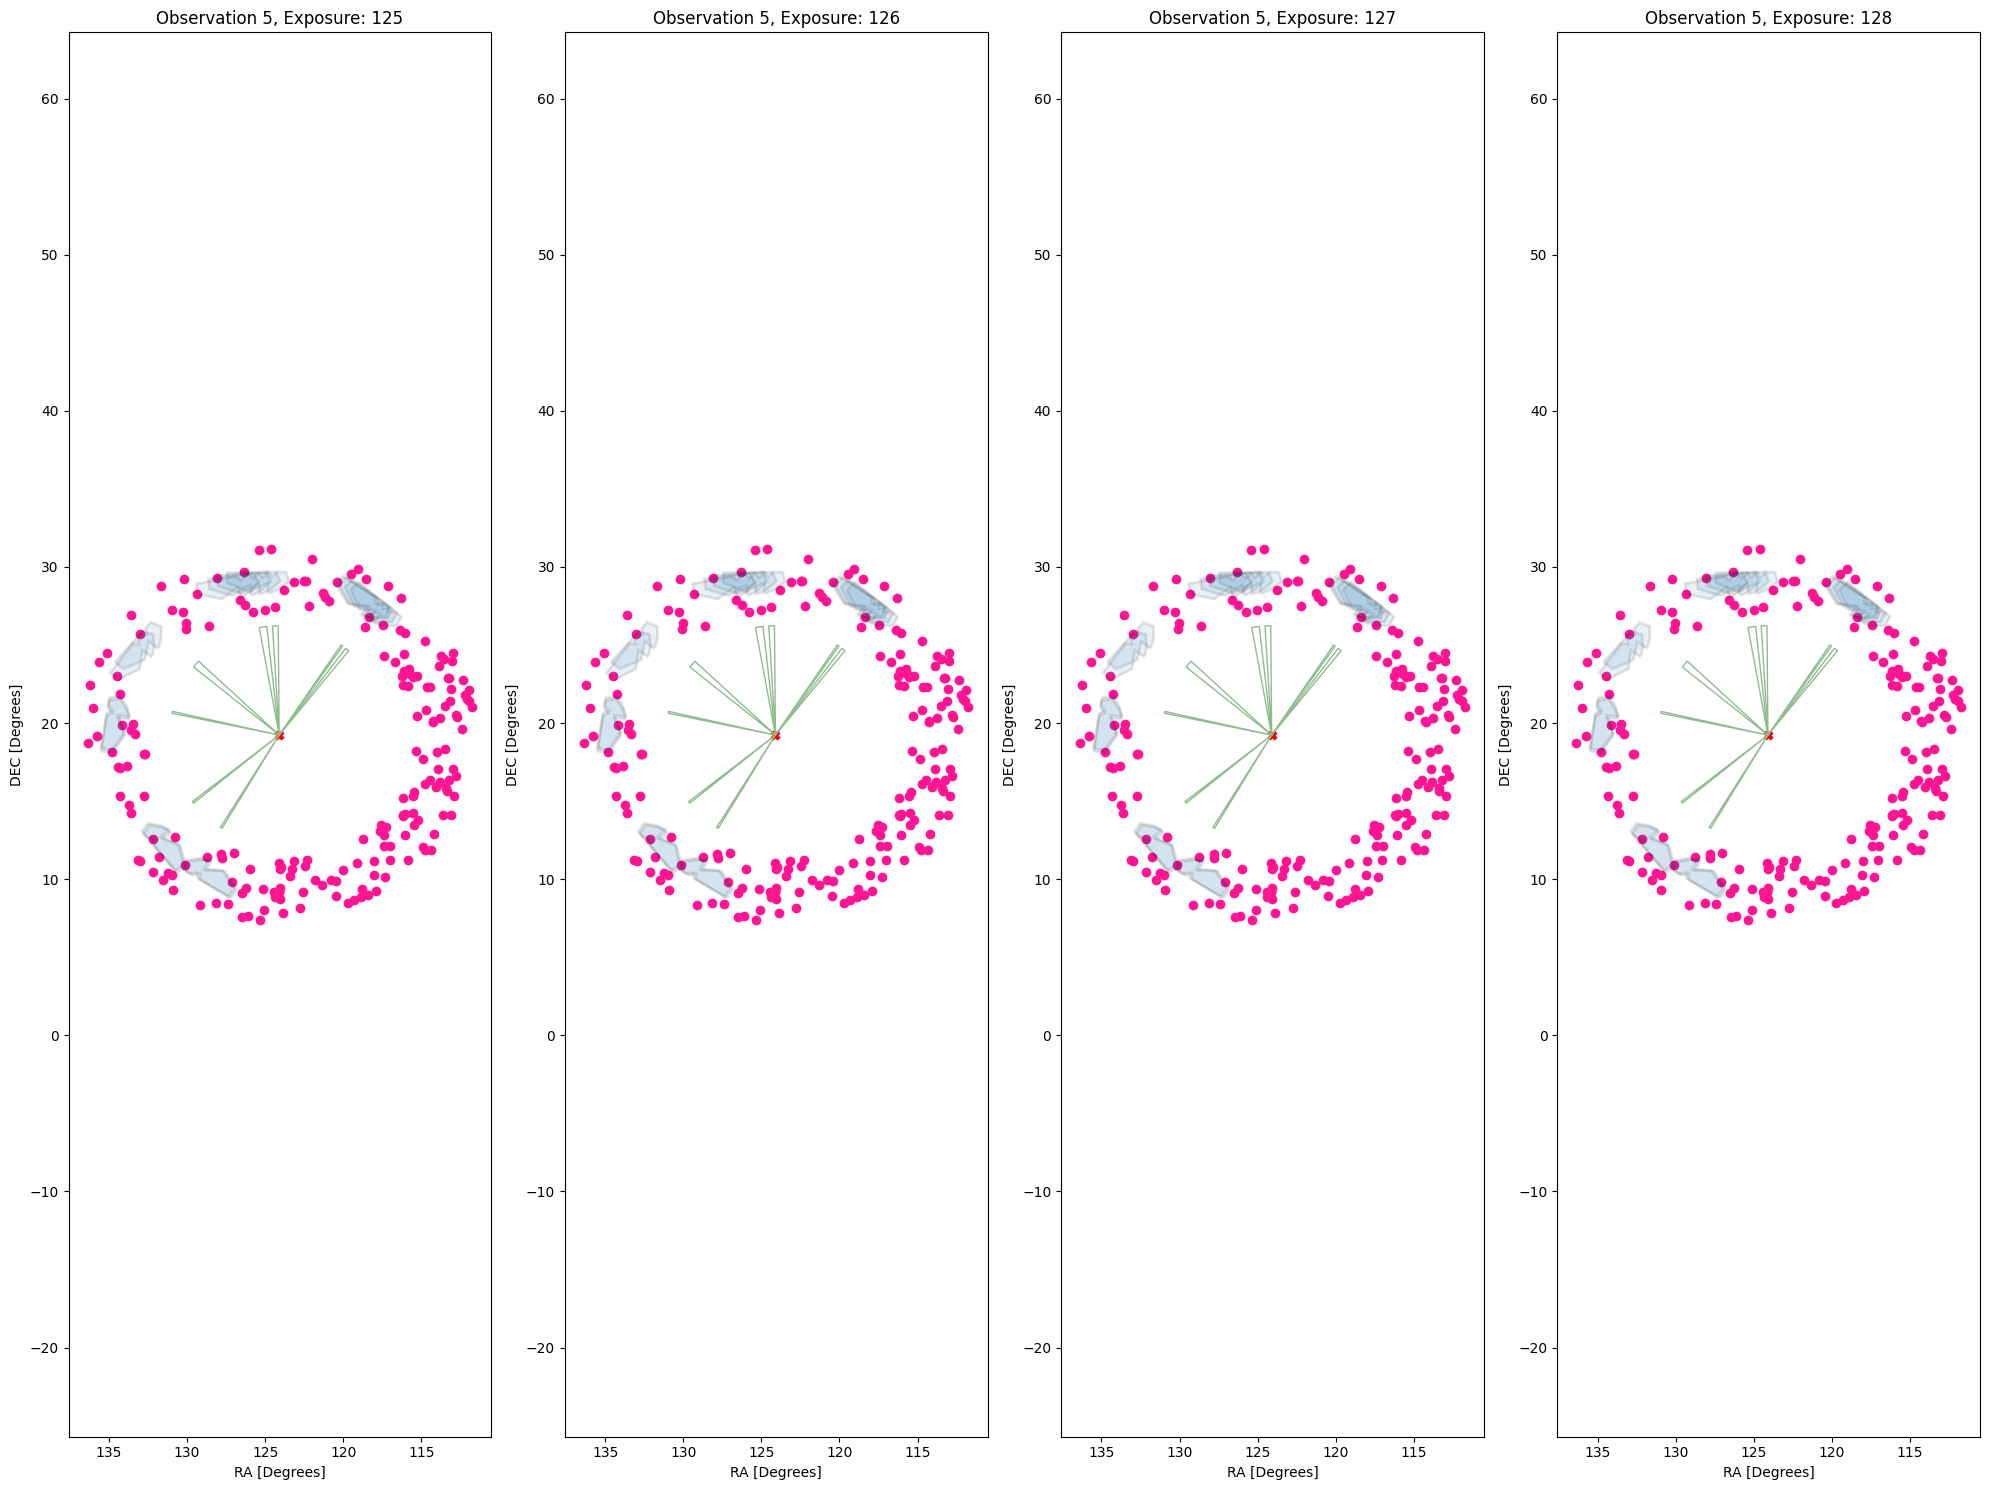

In [9]:
supported_observations = program.observations.supported_observations.keys()
for obs_number in supported_observations:
    program.plot_exposures(program.observations.data[obs_number])

<a id='observation-level-plots'></a>
### Observation Level Valid Angle Plots
The following plotting method will show valid angle ranges across all exposures in a single observation. If angles ranges are valid in one exposure but not in others, it will not be shown at this level. Here we plot all of the supported observations in our program.

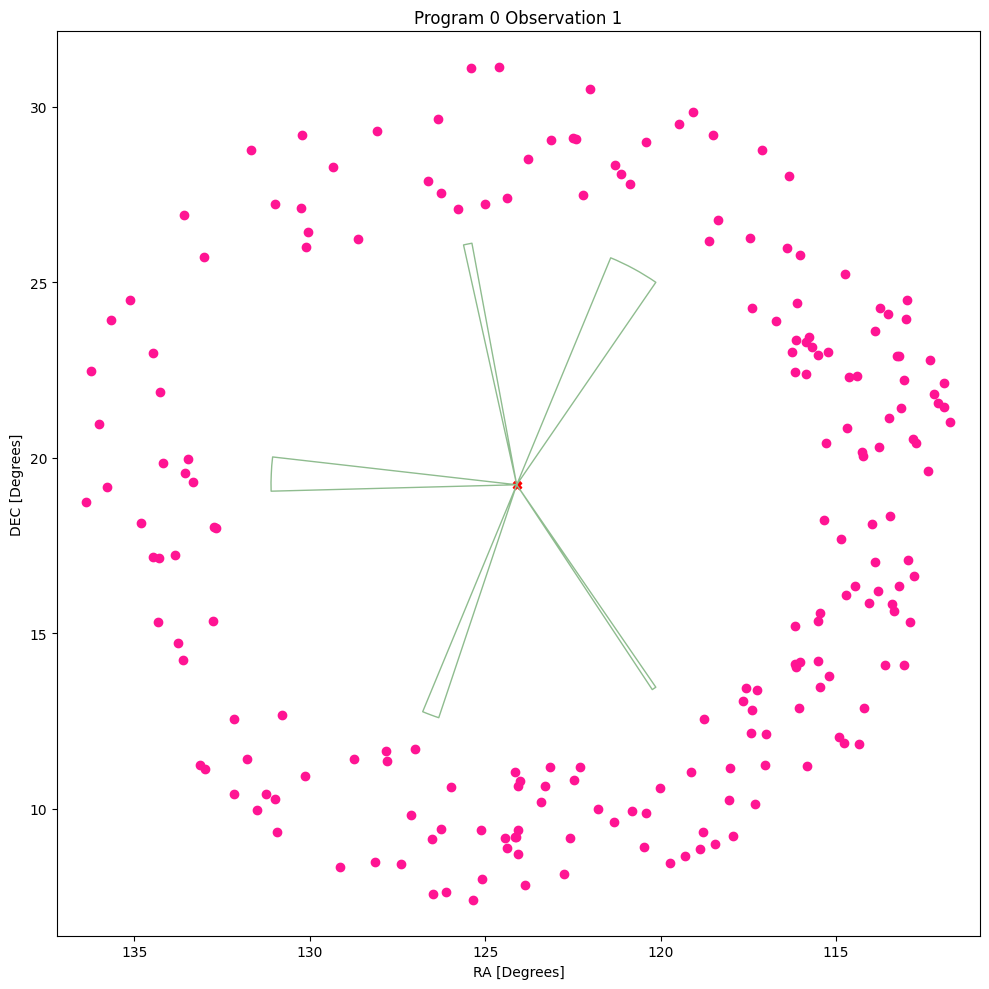

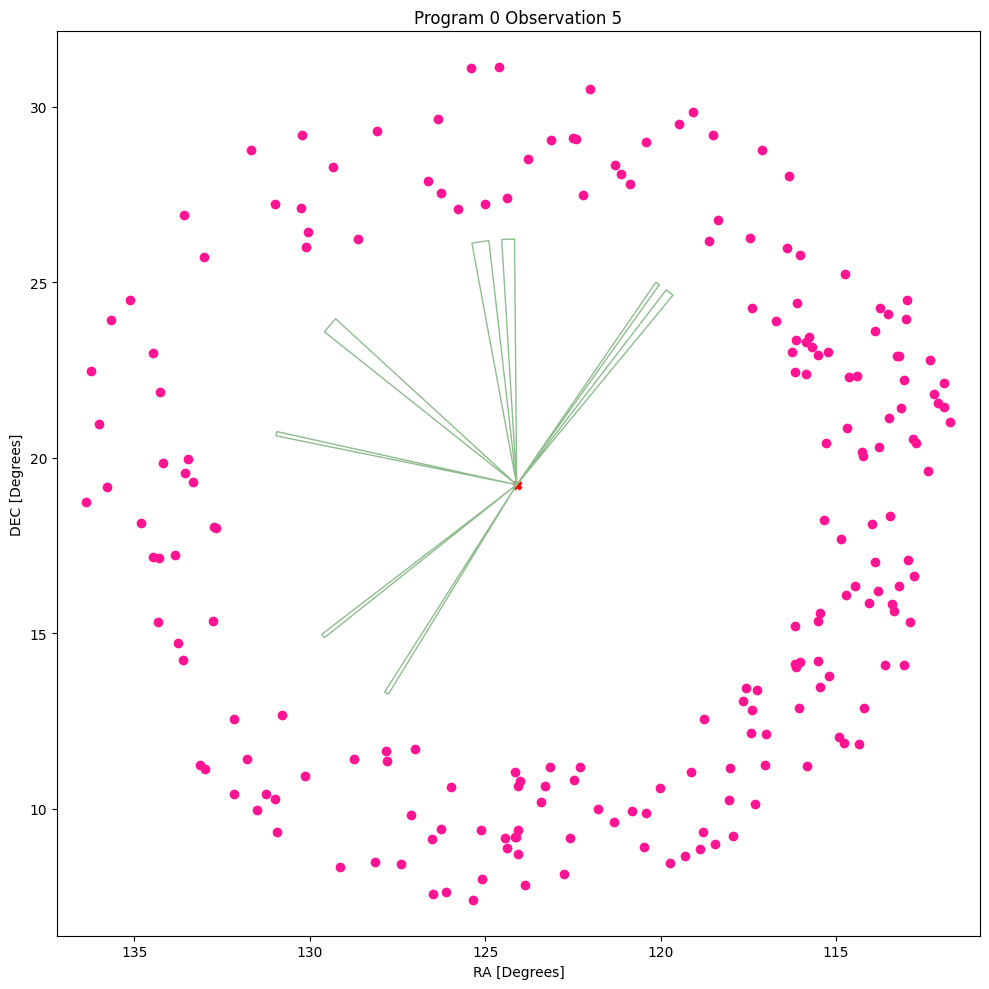

In [10]:
supported_observations = program.observations.supported_observations.keys()
for obs_number in supported_observations:
    program.plot_observation(program.observations.data[obs_number])

<a id='v2-vs-v3'></a>
### Plotting a Single Angle of Attitude in V2 & V3 Space

The figure below shows what the tool is searching for when sweeping angles. Here for a single angle we show the V2 & V3 space of the targets in our source catalog as well as the susceptibility region. The intensity of targets that fall in this region are dependent on the location where of the target in the susceptibility region and the brightness of the target.

<Figure size 1000x1000 with 0 Axes>

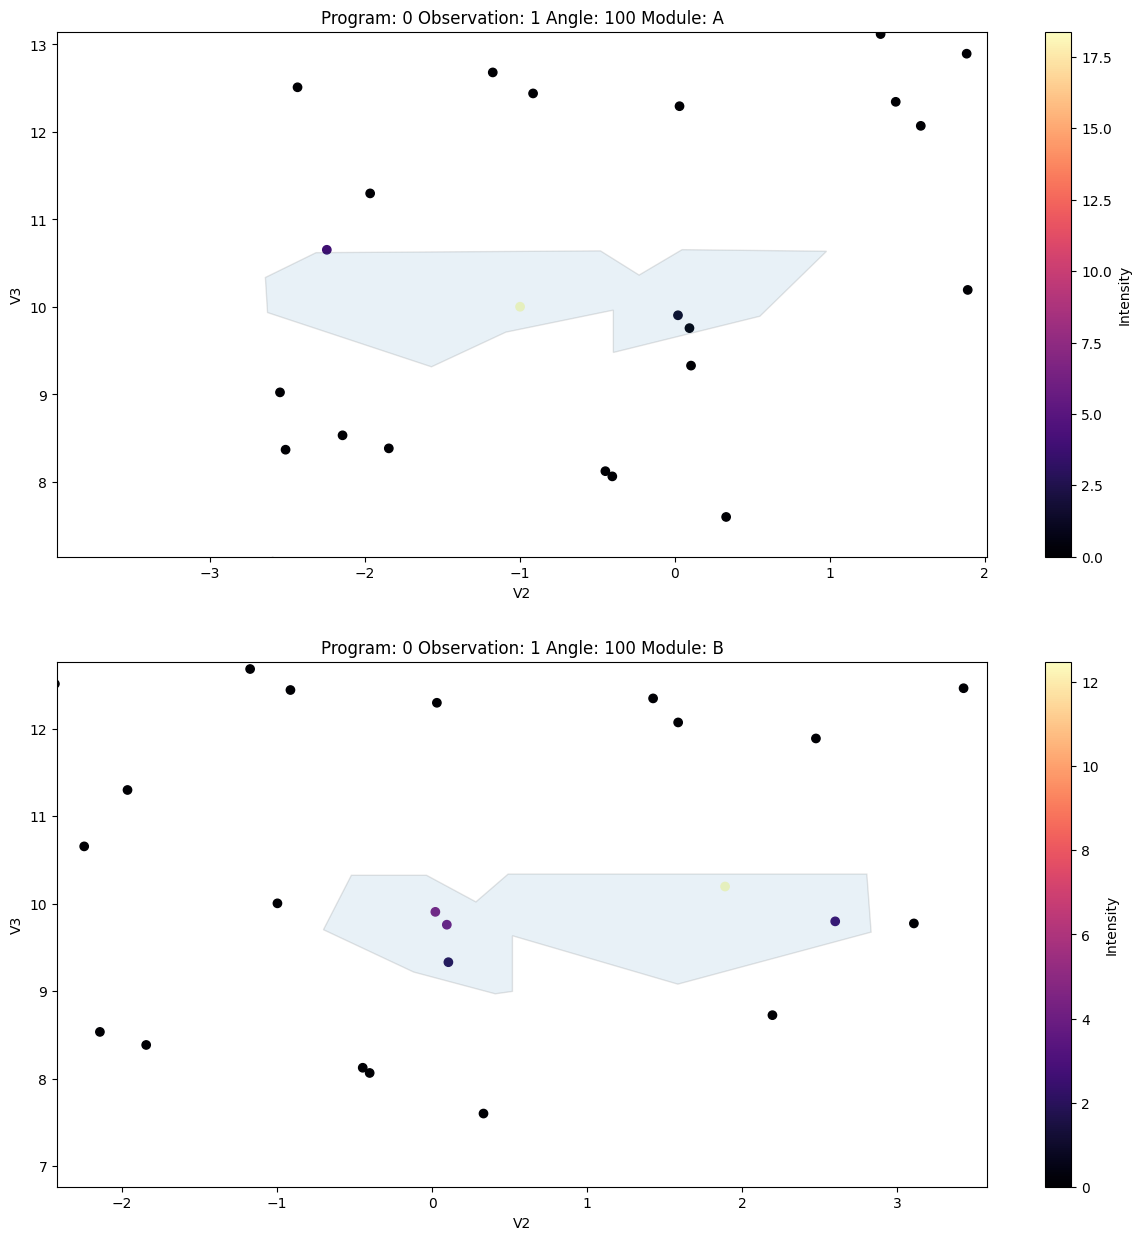

<Figure size 1000x1000 with 0 Axes>

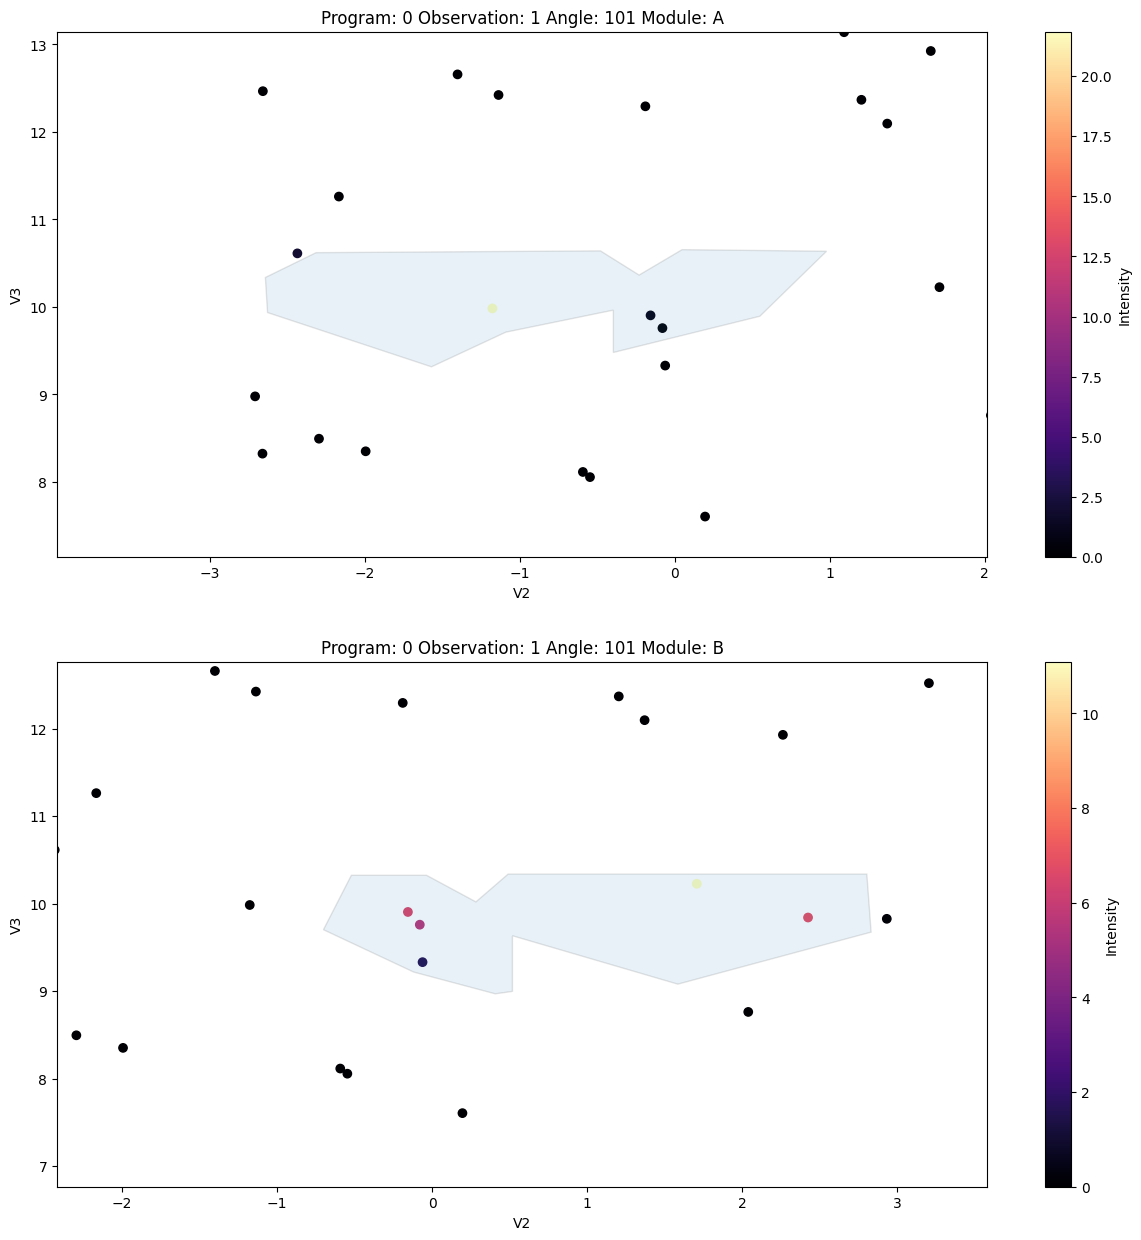

<Figure size 1000x1000 with 0 Axes>

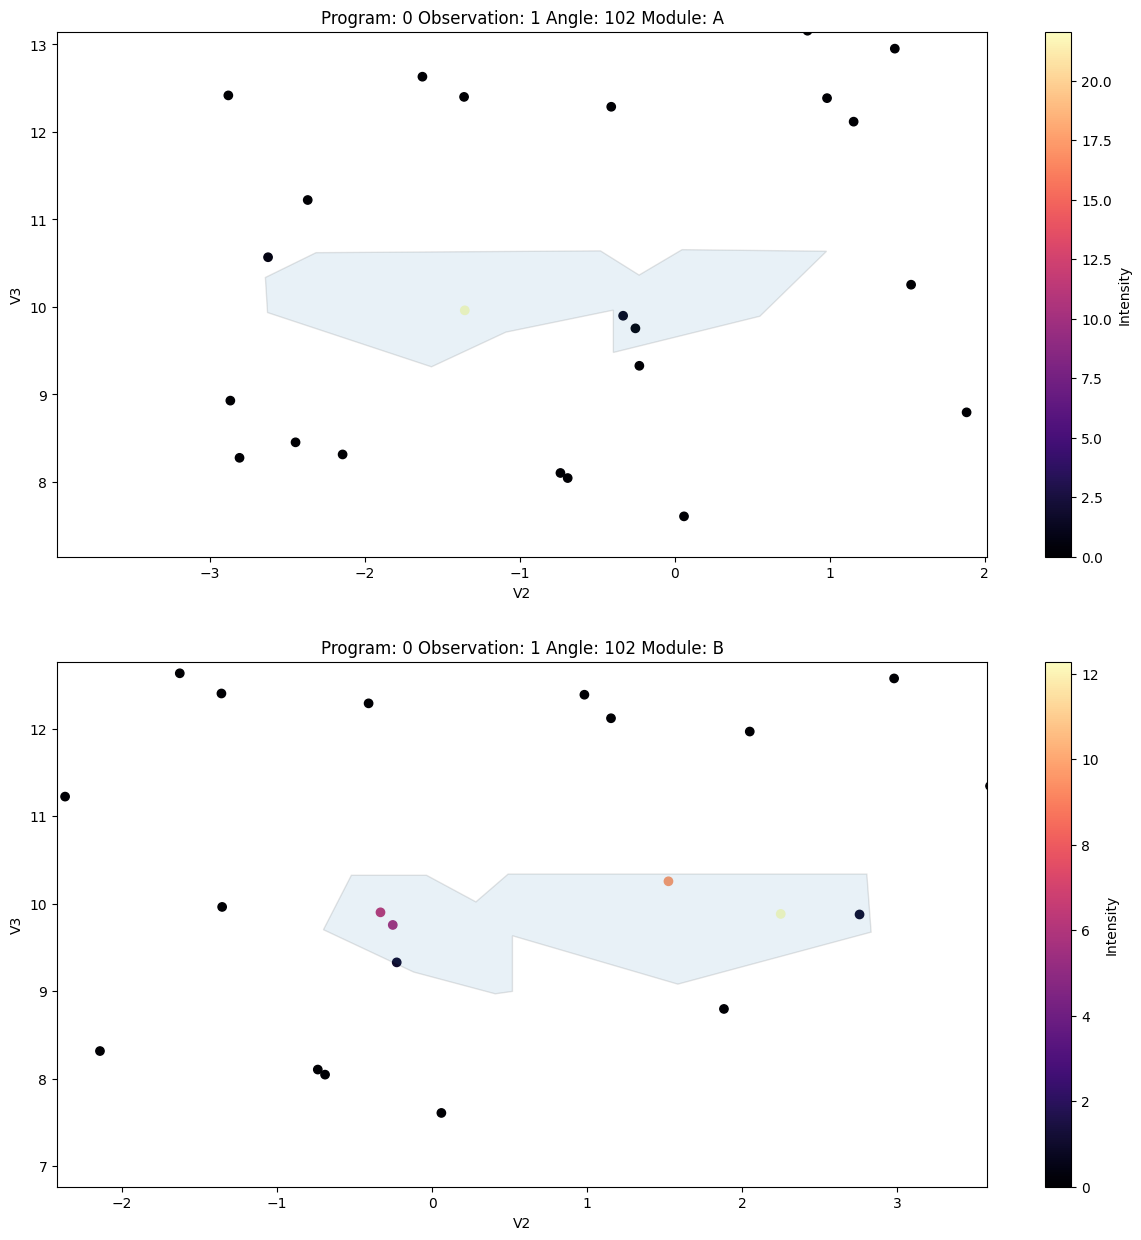

<Figure size 1000x1000 with 0 Axes>

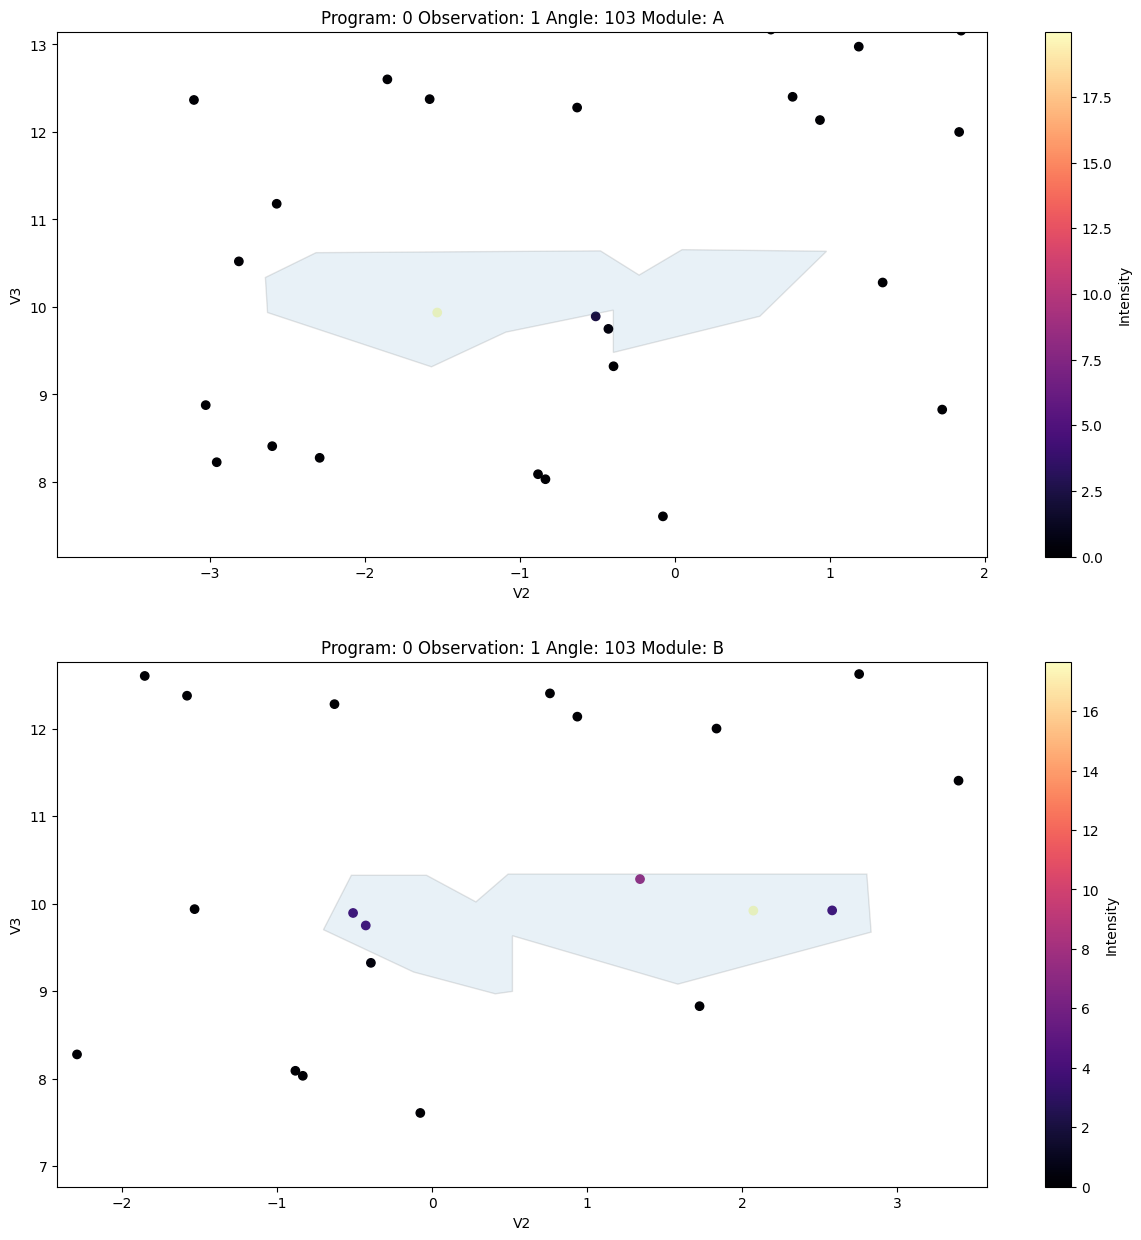

<Figure size 1000x1000 with 0 Axes>

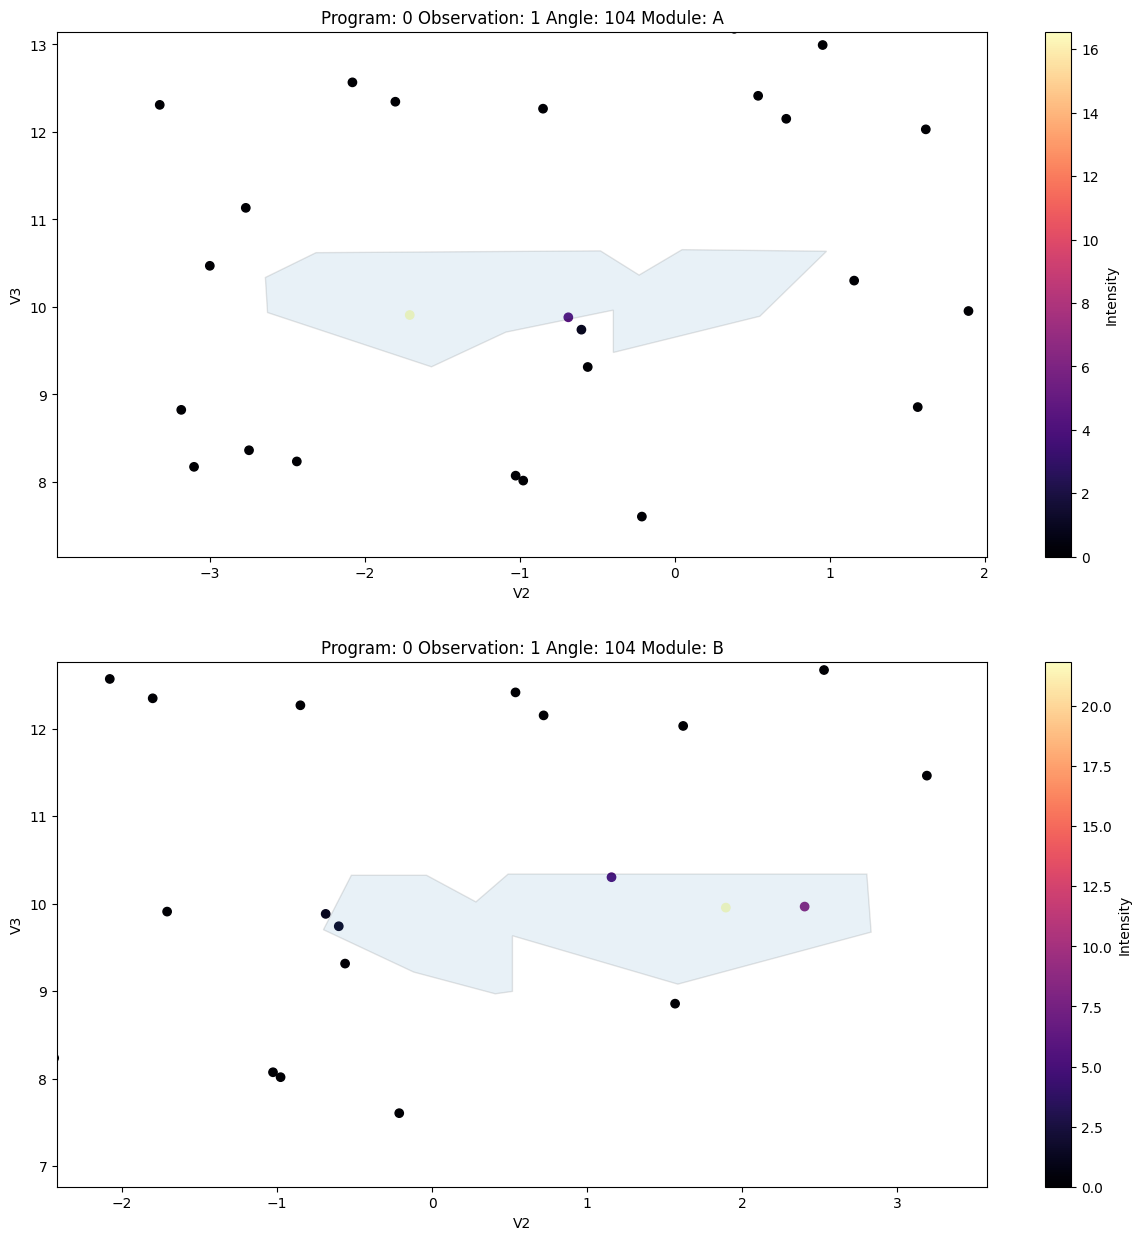

<Figure size 1000x1000 with 0 Axes>

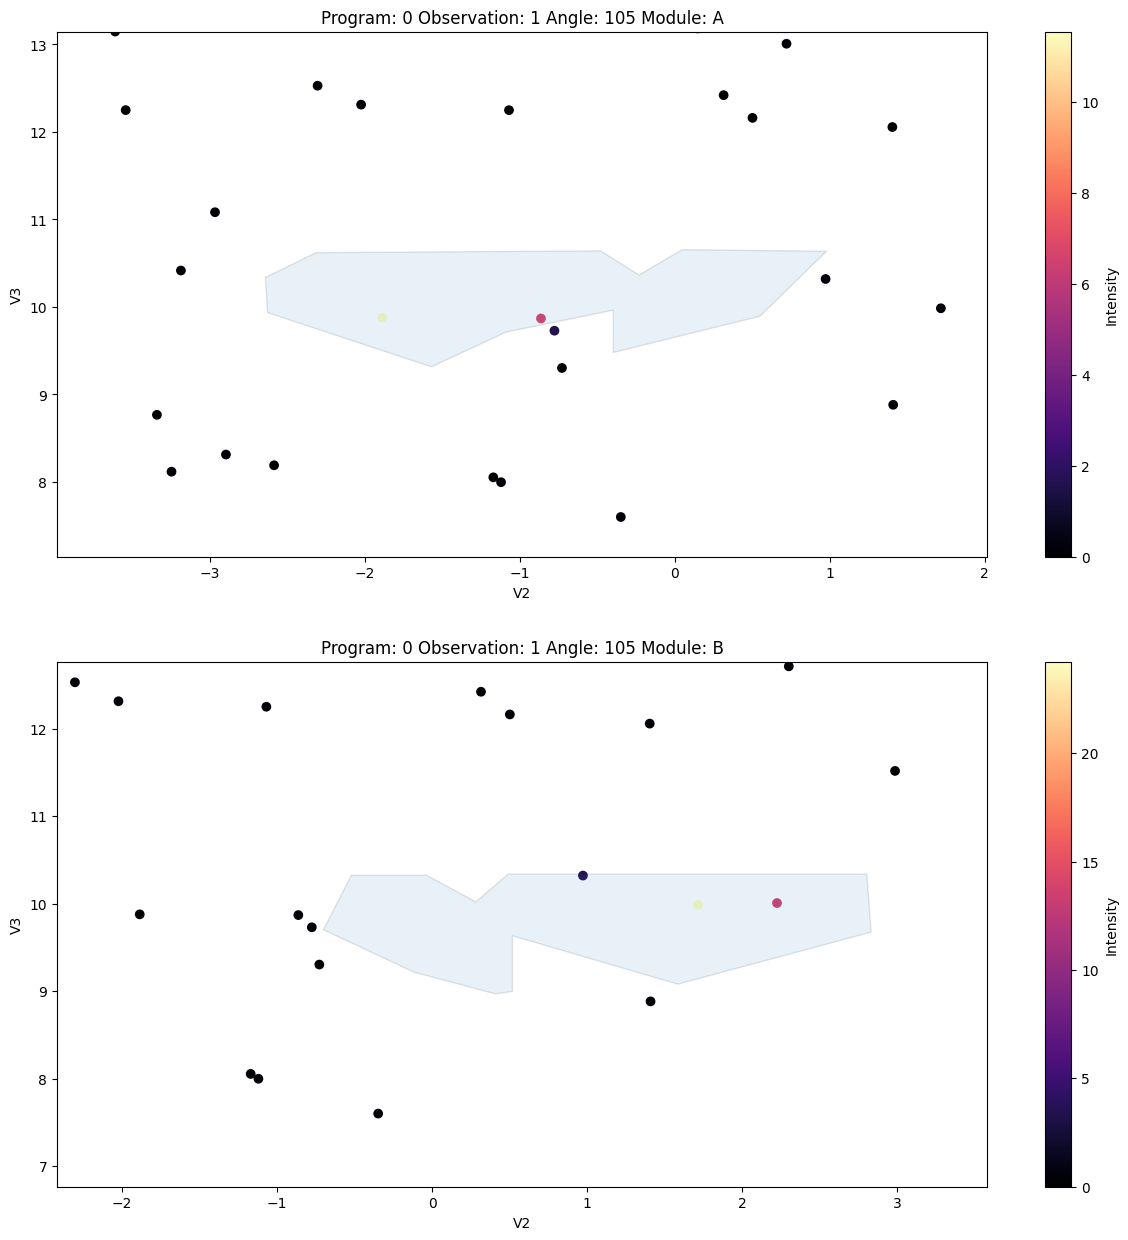

In [11]:
from jwst_rogue_path_tool.plotting import plot_fixed_angle_regions

angles = np.arange(100, 106)
observation = program.observations.data[1]

for angle in angles:
    plot_fixed_angle_regions(observation, angle)

<a id='attitude-vs-flux'></a>
### Flux as a Function of Attitude

Below we show the calculated flux as a function of attitude angle. This figure also ties in the [JWST Backgrounds Tool](https://github.com/spacetelescope/jwst_backgrounds) to calculate the background of the target JWST is observing described in the APT file. By default, we set the parameters for the backgrounds tool to calculate 10% of the minimum background value. You can set the function and percentage via a dictionary and pass it to the AptProgram class.
~~~
jbt_params = [{"threshold":0.1, function:np.min}, {"threshold":0.2, "function":np.mean}, ..... {"threshold":value, "function":stats_function}]

AptProgram(apt_JSON_filename, angular_step=1.0, bkg_params=jbt_params)
~~~

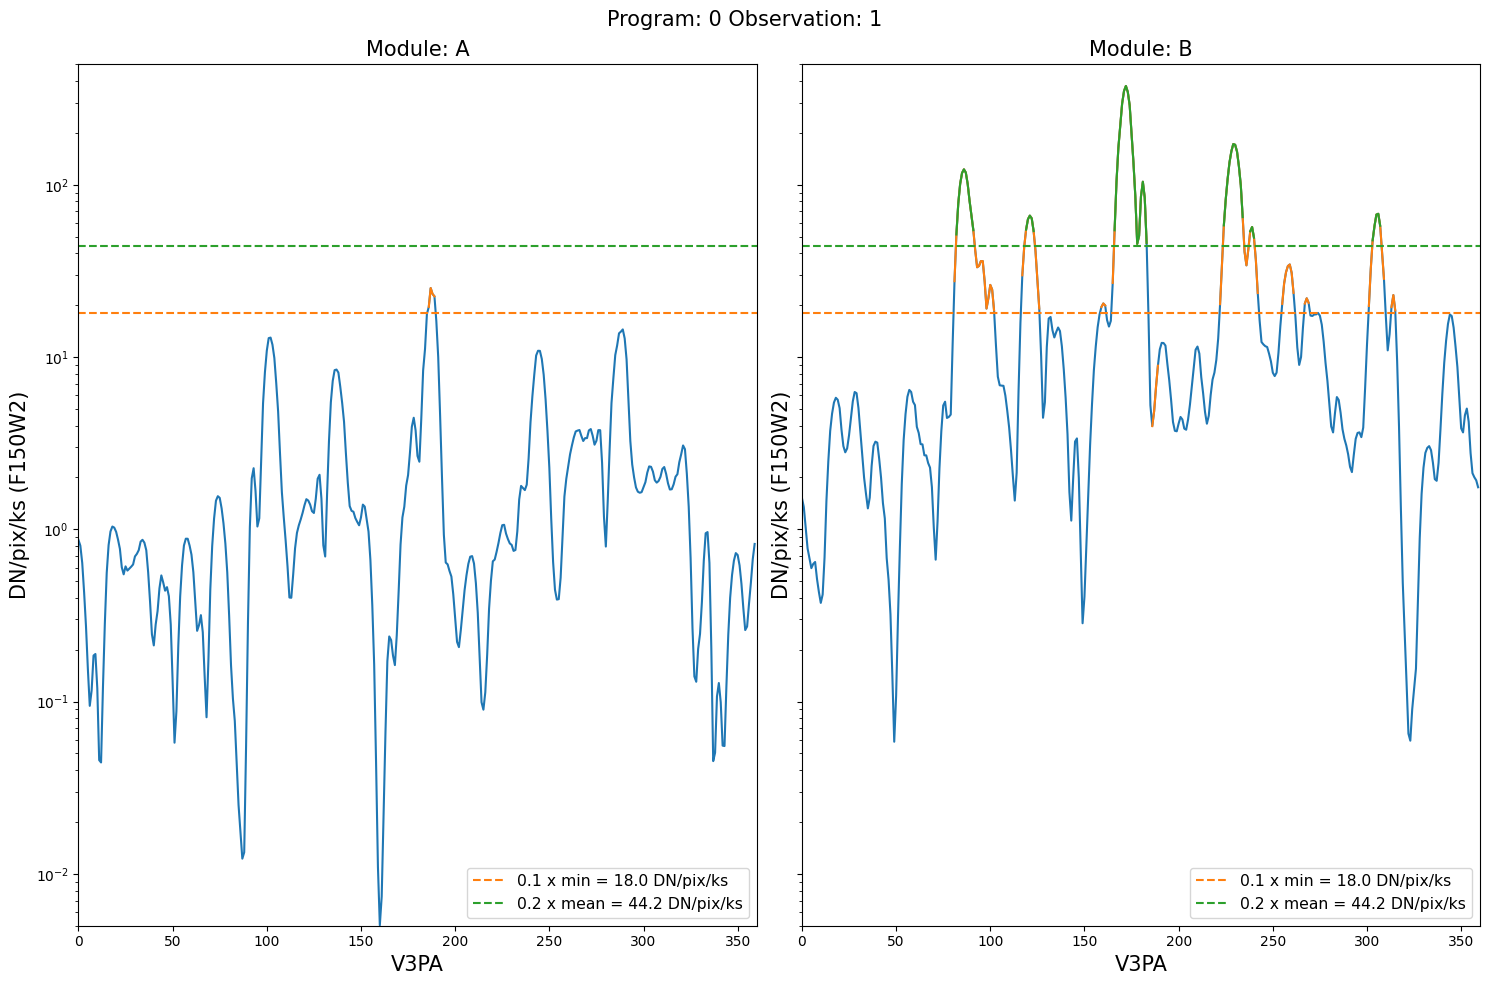

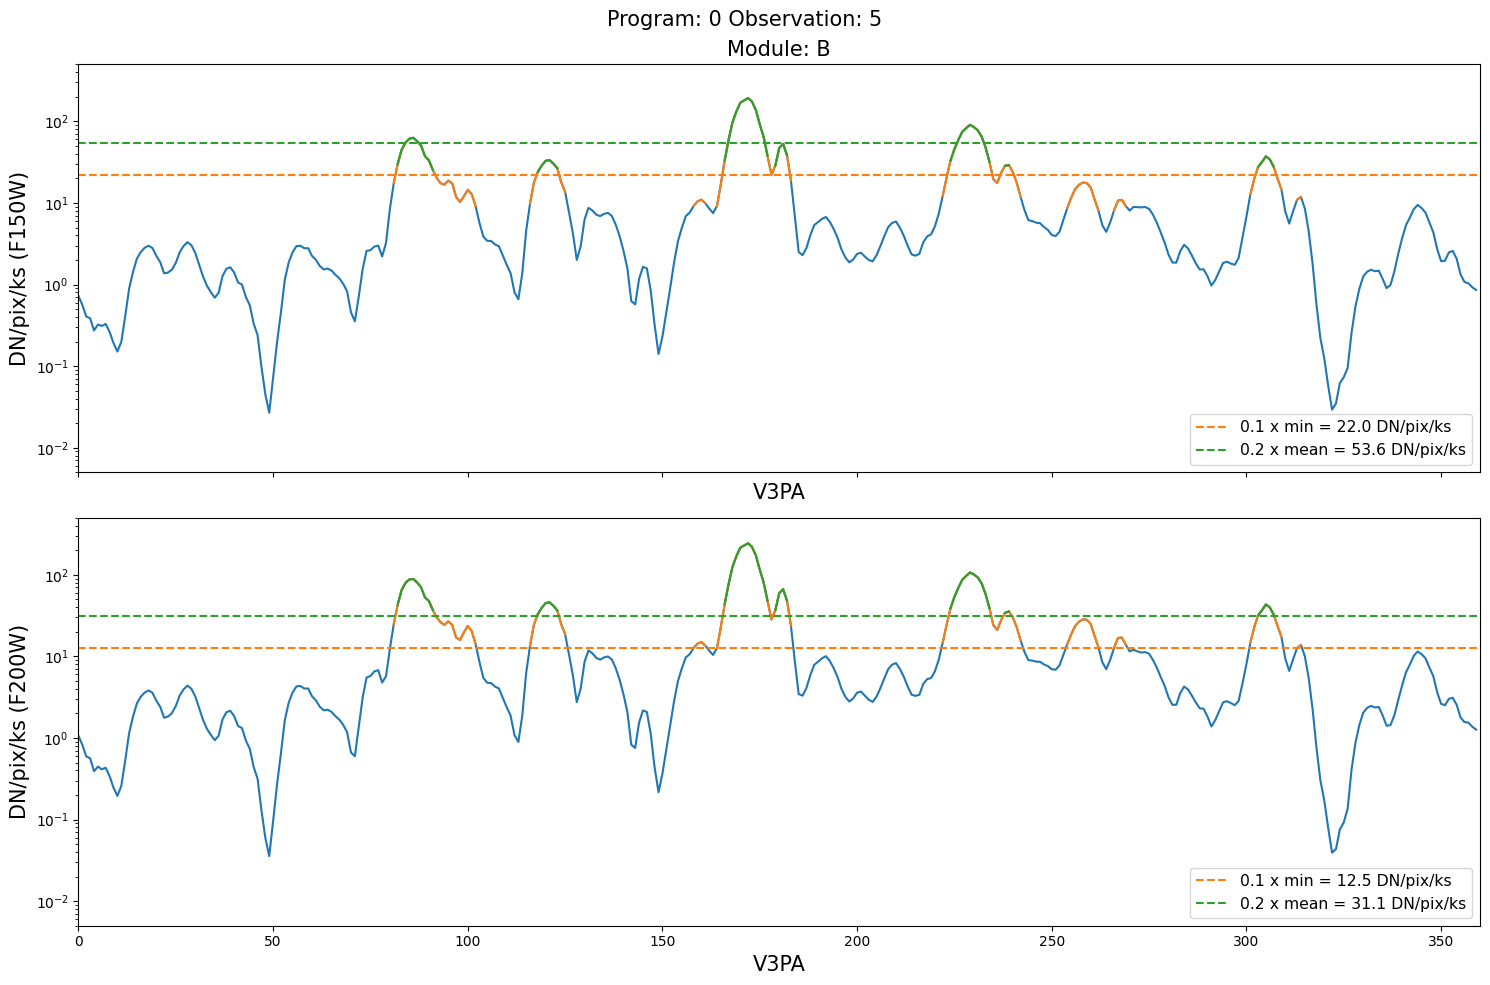

In [12]:
from jwst_rogue_path_tool.plotting import create_v3pa_vs_flux_plot

for obs_number in supported_observations:
    create_v3pa_vs_flux_plot(program.observations.data[obs_number])

<a id='reporting-and-apt'></a>
## Reporting & Applying PA Constraints in APT

In this section, we demonstrate how to plot the predicted claw flux across all position angles for a single observation, identify the angles free from claws, and modify the observation in APT to ensure it is taken only within those good position angle ranges.

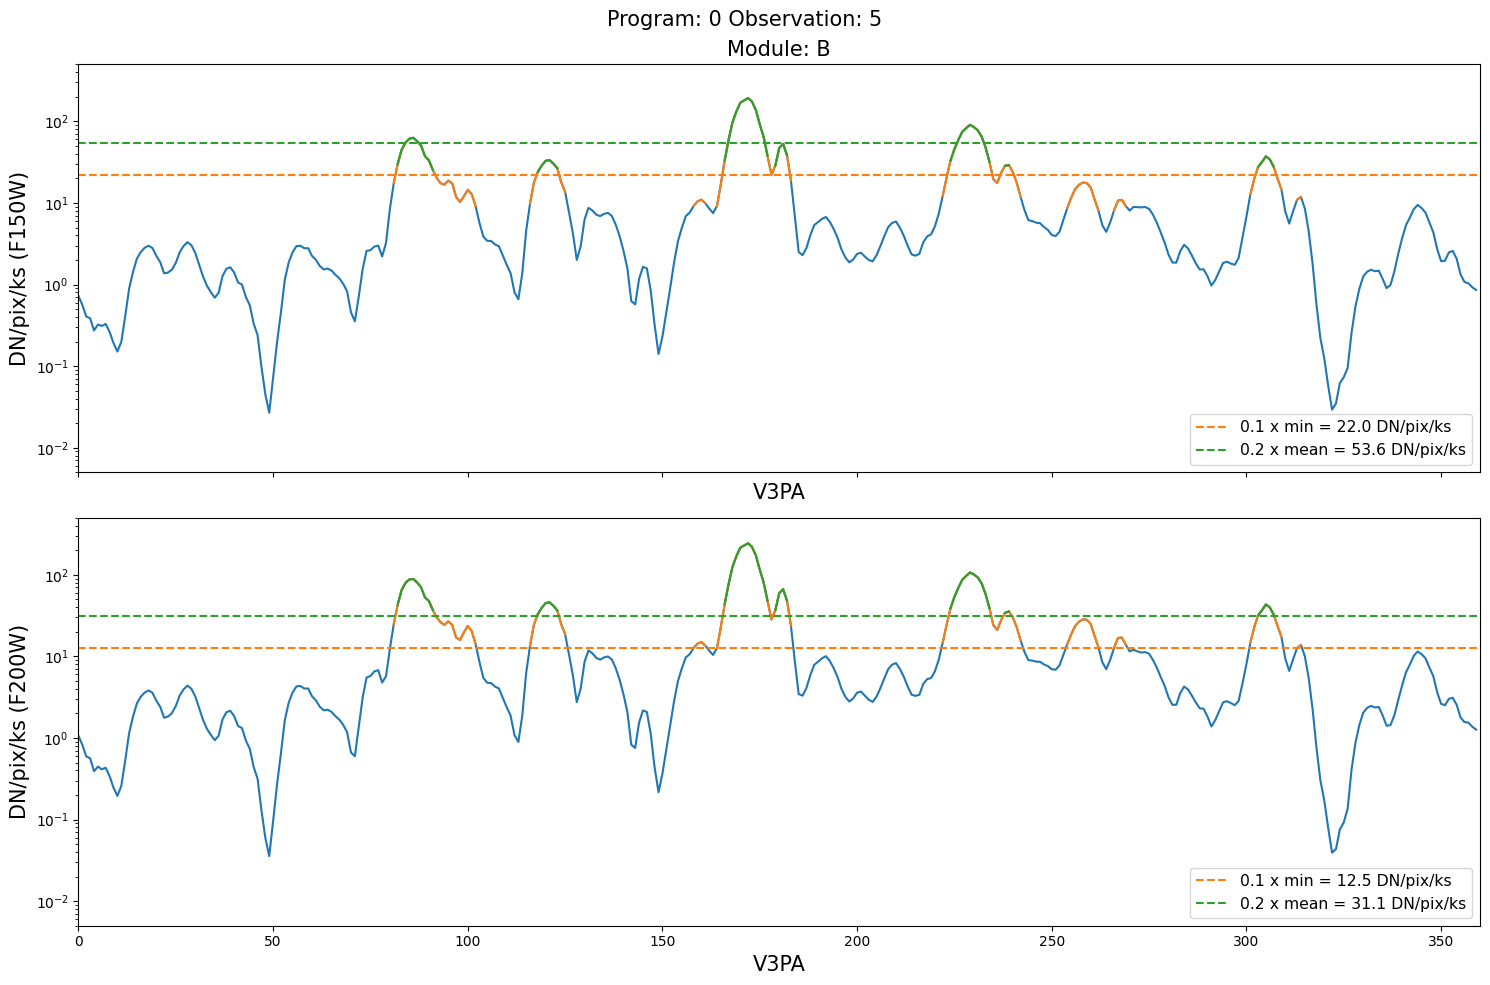

WROTE FILE TO: /home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/NIRCam/NIRCam_claw_detection/0/valid_angle_reports/program_0_observation_5_background_module_B.txt


In [13]:
# The observation number of interest
obs_number = 5

# Make plot of claws flux vs position angle
create_v3pa_vs_flux_plot(program.observations.data[obs_number])

# Make file containing good position angles
program.make_background_report(program.observations.data[obs_number], output_directory=pathlib.Path.cwd())

The plot above illustrates the predicted claw flux at each position angle for every filter. The horizontal orange and green lines indicate signal levels at 10% (based on minimum background throughout the year) and 20% (based on mean background throughout the year) of the predicted background levels, respectively. These thresholds help identify position angles free from claw contamination. Typically, the 20% threshold is sufficient, but for certain targets—such as faint, high-redshift objects—observers may prefer the more conservative 10% threshold. The PA ranges that are free from claws based on each threshold are saved to a text file, e.g. for this example observation `program_0_observation_5_background_module_B.txt`:
```
**** Ranges Not Impacted by Background Thresholds ****
**** Module B ****
**** Ranges Under 0.1 of min  ****
PA Start -- PA End: 0 -- 80
PA Start -- PA End: 103 -- 115
PA Start -- PA End: 126 -- 157
PA Start -- PA End: 162 -- 163
PA Start -- PA End: 184 -- 221
PA Start -- PA End: 243 -- 253
PA Start -- PA End: 263 -- 265
PA Start -- PA End: 270 -- 300
PA Start -- PA End: 310 -- 312
PA Start -- PA End: 315 -- 359
**** Ranges Under 0.2 of mean  ****
PA Start -- PA End: 0 -- 81
PA Start -- PA End: 92 -- 117
PA Start -- PA End: 124 -- 165
PA Start -- PA End: 178 -- 178
PA Start -- PA End: 183 -- 223
PA Start -- PA End: 235 -- 237
PA Start -- PA End: 240 -- 302
PA Start -- PA End: 308 -- 359
```

The PA ranges in this file are determined conservatively by considering all filters together. If the predicted claw flux in any filter exceeds the threshold, the corresponding position angle is excluded from these ranges.

<br>

Once the PA ranges free from claws are determined, users can add them to their APT files as a [PA Special Requirement](https://jwst-docs.stsci.edu/jppom/special-requirements/aperture-position-angle-special-requirements#gsc.tab=0) to ensure their observations are only taken within those PA ranges. To do this, select the observation in APT, then go to `Special Requirement→Add→Position Angle→PA Range` and input each good PA range in the V3PA Range boxes. Each PA range should be entered as a separate Special Requirement. For example, using the 20% threshold, the first Special Requirement for the example observation above would be:
```
Aperture PA Range 359.92542306 to 80.92542306 Degrees (V3 0.0 to 81.0)
```

Currently, the tool does not take into account target visibility, so some of the PA ranges shown may not need to be considered. For example, if a strong claw is predicted at a PA that is never available in the [roll analysis](https://jwst-docs.stsci.edu/jwst-astronomers-proposal-tool-overview/apt-workflow-articles/apt-visit-planner#gsc.tab=0), users don't have to include Special Requirements to avoid that PA as it will never be used anyway. To check which PA ranges are actually available for a given visit, users can go to `Visit Planner→Reports→Visitx.x→Total Roll Analysis For Visit`.